In [ ]:
import pandas as pd
from datetime import datetime
import os
import gc  # Per a gestió de memòria
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import calendar
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from scipy import stats
import os
import holidays

# 1. CONFIGURACIÓ INICIAL ---------------------------------------------------
# Ruta base on es troben els arxius de dades
BASE_PATH = r"G:\Mi unidad\IT ACADEMY\Reskilling Data Analytics\SPRINT 10\Brazilian E-Commerce Public Dataset"

# 2. DICCIONARI DE TRADUCCIONS CATALANES ------------------------------------
TRADUCCIONS_CA = {
    "health_beauty": "salut_bellesa",
    "computers_accessories": "accessoris_informàtics",
    "auto": "automòbil",
    "bed_bath_table": "llit_bany_taula",
    "furniture_decor": "mobles_decoració",
    "sports_leisure": "esports_oci",
    "perfumery": "perfumeria",
    "housewares": "articles_llar",
    "telephony": "telefonia",
    "watches_gifts": "rellotges_regals",
    "food_drink": "aliments_begudes",
    "baby": "nadons",
    "stationery": "papereria",
    "tablets_printing_image": "tauletes_impressió_imatge",
    "toys": "joguines",
    "fixed_telephony": "telefonia_fixa",
    "garden_tools": "eines_jardí",
    "fashion_bags_accessories": "moda_bolsos_accessoris",
    "small_appliances": "electrodomèstics_petits",
    "consoles_games": "consoles_jocs",
    "audio": "àudio",
    "fashion_shoes": "moda_calçat",
    "cool_stuff": "productes_interessants",
    "luggage_accessories": "equipatge_accessoris",
    "air_conditioning": "aire_condicionat",
    "construction_tools_construction": "eines_construcció",
    "kitchen_dining_laundry_garden_furniture": "mobles_cuina_menjador_rentavanderia_jardí",
    "costruction_tools_garden": "eines_construcció_jardí",
    "fashion_male_clothing": "moda_roba_home",
    "pet_shop": "botiga_mascotes",
    "office_furniture": "mobles_oficina",
    "market_place": "mercat",
    "electronics": "electrònica",
    "home_appliances": "electrodomèstics_llar",
    "party_supplies": "subministres_festa",
    "home_confort": "llar_confort",
    "costruction_tools_tools": "eines_construcció",
    "agro_industry_and_commerce": "agroindústria_comerç",
    "furniture_mattress_and_upholstery": "mobles_matalàs_tapisseria",
    "books_technical": "llibre_tècnics",
    "home_construction": "construcció_llar",
    "musical_instruments": "instruments_musicals",
    "furniture_living_room": "mobles_sala_estar",
    "construction_tools_lights": "eines_construcció_il·luminació",
    "industry_commerce_and_business": "indústria_comerç_negocis",
    "food": "aliments",
    "art": "art",
    "furniture_bedroom": "mobles_dormitori",
    "books_general_interest": "llibres_interès_general",
    "construction_tools_safety": "eines_construcció_seguretat",
    "fashion_underwear_beach": "moda_roba_interior_platja",
    "fashion_sport": "moda_esportiva",
    "signaling_and_security": "senyalització_seguretat",
    "computers": "ordinadors",
    "christmas_supplies": "subministres_nadal",
    "fashio_female_clothing": "moda_roba_dona",
    "home_appliances_2": "electrodomèstics_llar_2",
    "books_imported": "llibres_importats",
    "drinks": "begudes",
    "cine_photo": "cinema_fotografia",
    "la_cuisine": "cuina",
    "music": "música",
    "home_comfort_2": "llar_confort_2",
    "small_appliances_home_oven_and_coffee": "electrodomèstics_petits_forn_cafè",
    "cds_dvds_musicals": "cds_dvds_musicals",
    "dvds_blu_ray": "dvds_blu_ray",
    "flowers": "flors",
    "arts_and_craftmanship": "arts_artesania",
    "diapers_and_hygiene": "bolquers_higiene",
    "fashion_childrens_clothes": "moda_roba_infantil",
    "security_and_services": "seguretat_serveis"
}


# 3. CARREGA DE DADES ESSENCIALS --------------------------------------------
# Diccionari amb els arxius i els seus noms
arxius = {
    'orders': 'olist_orders_dataset.csv',
    'customers': 'olist_customers_dataset.csv',
    'order_items': 'olist_order_items_dataset.csv',
    'products': 'olist_products_dataset.csv',
    'traduccio': 'product_category_name_translation.csv'
}

# Diccionari per emmagatzemar els DataFrames carregats
dfs = {}

# 3.1. Definir columnes de temps per a cada taula
TIMESTAMP_COLS = {
    'orders': [
        'order_purchase_timestamp',
        'order_approved_at',
        'order_delivered_carrier_date',
        'order_delivered_customer_date',
        'order_estimated_delivery_date'
    ],
    'order_items': [
        'shipping_limit_date'
    ]
}

# 3.2. Funció per convertir timestamps
def convertir_timestamps(df, nom_taula):
    """Converteix les columnes de temps a datetime64"""
    if nom_taula in TIMESTAMP_COLS:
        for col in TIMESTAMP_COLS[nom_taula]:
            if col in df.columns:
                df[col] = pd.to_datetime(df[col], errors='coerce')
                # Optimitzar memòria
                df[col] = df[col].astype('datetime64[s]')
    return df

# 3.3. Carregar i convertir dades
for nom, arxiu in arxius.items():
    ruta_completa = os.path.join(BASE_PATH, arxiu)
    dfs[nom] = pd.read_csv(ruta_completa)
    dfs[nom] = convertir_timestamps(dfs[nom], nom)
    print(f"✅ {arxiu} carregat i timestamps convertits per a '{nom}'")

# 4. PREPARACIÓ DE DADES DE PRODUCTES ---------------------------------------
# Fusionar productes amb traduccions angleses
dfs['products'] = dfs['products'].merge(
    dfs['traduccio'], 
    on='product_category_name', 
    how='left'
)

# Afegir traducció catalana utilitzant el diccionari
dfs['products']['categoria_catala'] = (
    dfs['products']['product_category_name_english']
    .map(TRADUCCIONS_CA)
    .astype('category')  # Estalvi de memòria
)

# Verificar categories sense traducció
categories_faltants = dfs['products'][dfs['products']['categoria_catala'].isna()]
if not categories_faltants.empty:
    faltants = categories_faltants['product_category_name_english'].unique()
    print(f"⚠️ ATENCIÓ: {len(faltants)} categories sense traducció catalana")
    print(faltants)
else:
    print("✅ Totes les categories traduïdes al català")

# 5. FUSIÓ DE TAULES PER CREAR EL DATAFRAME FINAL ---------------------------
# Fusionar comandes amb clients
df_final = dfs['orders'].merge(
    dfs['customers'], 
    on='customer_id', 
    how='left'
)

# Fusionar amb ítems de comanda
df_final = df_final.merge(
    dfs['order_items'], 
    on='order_id', 
    how='left'
)

# Fusionar amb productes (incloent la categoria en català)
df_final = df_final.merge(
    dfs['products'][['product_id', 'categoria_catala']], 
    on='product_id', 
    how='left'
)

# 6. VERIFICACIÓ FINAL DE TIMESTAMPS ----------------------------------------
print("\n" + "="*50)
print("VERIFICACIÓ FINAL DE TIMESTAMPS")

# Llistar totes les columnes de temps
timestamp_cols = [col for col in df_final.columns if any(kw in col for kw in ['date', 'time', 'stamp'])]

for col in timestamp_cols:
    if col in df_final.columns:
        dtype = df_final[col].dtype
        null_count = df_final[col].isnull().sum()
        print(f"- {col}:")
        print(f"  Tipus: {dtype}")
        print(f"  Valors nuls: {null_count} ({null_count/len(df_final):.2%})")
        
        # Mostrar rang temporal si és una columna vàlida
        if pd.api.types.is_datetime64_any_dtype(dtype):
            print(f"  Rang: {df_final[col].min()} a {df_final[col].max()}")
    else:
        print(f"- {col}: NO PRESENT EN EL DATAFRAME FINAL")


# 8. NETEGEA I VERIFICACIÓ FINAL --------------------------------------------
# Alliberar memòria
del dfs
gc.collect()

# Mostrar resultat
print("\n" + "="*50)
print(f"📊 DATAFRAME FINAL CREAT: {df_final.shape[0]} files, {df_final.shape[1]} columnes")
print("Mostrant 3 files de mostra:")
print(df_final[['order_id', 'product_id', 'categoria_catala']].head(3))
print("\n📅 RANG TEMPORAL DE LES DADES:")
print(f"Data primera comanda: {df_final['order_purchase_timestamp'].min()}")
print(f"Data última comanda: {df_final['order_purchase_timestamp'].max()}")

# 9. GESTIÓ DE VALORS NULS EN TIMESTAMPS ------------------------------------

def gestionar_valors_nuls(df):
    """Gestiona valors nuls en columnes de temps amb estratègies específiques"""
    # Crear còpia per evitar Side Effects
    df = df.copy()
    
    print("\n" + "="*50)
    print("GESTIÓ DE VALORS NULS EN TIMESTAMPS")
    
    # A. order_delivered_carrier_date (1.74% nuls)
    # Estratègia: Imputar basat en temps mitjà de processament
    if 'order_delivered_carrier_date' in df.columns:
        # Calcular temps mitjà entre compra i lliurament al transportista
        mask = df['order_delivered_carrier_date'].notna()
        avg_process_time = (
            df.loc[mask, 'order_delivered_carrier_date'] - 
            df.loc[mask, 'order_purchase_timestamp']
        ).mean()
        
        # Imputar valors
        null_mask = df['order_delivered_carrier_date'].isna()
        df.loc[null_mask, 'order_delivered_carrier_date'] = (
            df.loc[null_mask, 'order_purchase_timestamp'] + avg_process_time
        )
        print(f"✅ order_delivered_carrier_date: {null_mask.sum()} valors imputats")
    
    # B. order_delivered_customer_date (2.85% nuls)
    # Estratègia: Imputar basat en temps mitjà de transport
    if 'order_delivered_customer_date' in df.columns:
        # Calcular temps mitjà entre lliurament a transportista i client
        mask = df['order_delivered_customer_date'].notna() & df['order_delivered_carrier_date'].notna()
        avg_transit_time = (
            df.loc[mask, 'order_delivered_customer_date'] - 
            df.loc[mask, 'order_delivered_carrier_date']
        ).mean()
        
        # Imputar valors
        null_mask = df['order_delivered_customer_date'].isna()
        df.loc[null_mask, 'order_delivered_customer_date'] = (
            df.loc[null_mask, 'order_delivered_carrier_date'] + avg_transit_time
        )
        print(f"✅ order_delivered_customer_date: {null_mask.sum()} valors imputats")
    
    return df

# Aplicar gestió de valors nuls
df_final = gestionar_valors_nuls(df_final)

# 8. VERIFICACIÓ FINAL DE VALORS NULS DESPRÉS DE LA GESTIÓ -----------------
print("\n" + "="*50)
print("VERIFICACIÓ FINAL DESPRÉS DE LA GESTIÓ DE NULS")

# Tornem a verificar les mateixes columnes
timestamp_cols = [
    'order_purchase_timestamp',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
]

for col in timestamp_cols:
    if col in df_final.columns:
        dtype = df_final[col].dtype
        null_count = df_final[col].isnull().sum()
        print(f"- {col}:")
        print(f"  Tipus: {dtype}")
        print(f"  Valors nuls: {null_count} ({null_count/len(df_final):.2%})")
        
        # Mostrar rang temporal si és una columna vàlida
        if pd.api.types.is_datetime64_any_dtype(dtype):
            print(f"  Rang: {df_final[col].min()} a {df_final[col].max()}")
    else:
        print(f"- {col}: NO PRESENT EN EL DATAFRAME FINAL")

# 9. CREACIÓ DE COLUMNES TEMPORALS PER A ANÀLISIS ----------------------

print("\n" + "="*50)
print("CREACIÓ DE COLUMNES TEMPORALS PER A ANÀLISIS")

# Crear columnes derivades per a diferents nivells d'agregació
df_final['any'] = df_final['order_purchase_timestamp'].dt.year
df_final['mes'] = df_final['order_purchase_timestamp'].dt.month
df_final['setmana'] = df_final['order_purchase_timestamp'].dt.isocalendar().week
df_final['dia_any'] = df_final['order_purchase_timestamp'].dt.dayofyear
df_final['dia_setmana'] = df_final['order_purchase_timestamp'].dt.day_name()
df_final['hora'] = df_final['order_purchase_timestamp'].dt.hour

# Crear un període mensual per a anàlisis de sèries temporals
df_final['periode_mensual'] = df_final['order_purchase_timestamp'].dt.to_period('M')

# Optimitzar memòria
df_final['any'] = df_final['any'].astype('int16')
df_final['mes'] = df_final['mes'].astype('int8')
df_final['setmana'] = df_final['setmana'].astype('int8')
df_final['dia_any'] = df_final['dia_any'].astype('int16')
df_final['hora'] = df_final['hora'].astype('int8')

# 10. PREPARACIÓ PER A ANÀLISIS TEMPORALS -----------------------------
# Diccionari de noms de mesos en català
MESOS_CATALA = {
    1: 'Gener', 2: 'Febrer', 3: 'Març', 4: 'Abril', 5: 'Maig', 6: 'Juny',
    7: 'Juliol', 8: 'Agost', 9: 'Setembre', 10: 'Octubre', 11: 'Novembre', 12: 'Desembre'
}

# Afegir noms de mesos en català
df_final['mes_nom'] = df_final['mes'].map(MESOS_CATALA).astype('category')

# Ordenar categories de dies de la setmana
dies_ordre = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_final['dia_setmana'] = df_final['dia_setmana'].astype(
    pd.CategoricalDtype(categories=dies_ordre, ordered=True)
)

# 11. NETEGEA I VERIFICACIÓ FINAL --------------------------------------------
# Alliberar memòria de objectes intermedis
if 'dfs' in locals():
    del dfs
gc.collect()

# Mostrar resultat final
print("\n" + "="*50)
print(f"📊 DATAFRAME FINAL CREAT: {df_final.shape[0]} files, {df_final.shape[1]} columnes")
print("\nMostrant 3 files de mostra:")
print(df_final[['order_id', 'product_id', 'categoria_catala', 
                'order_purchase_timestamp', 'mes_nom', 'dia_setmana']].head(3))
print("\n📅 RANG TEMPORAL DE LES DADES:")
print(f"Data primera comanda: {df_final['order_purchase_timestamp'].min()}")
print(f"Data última comanda: {df_final['order_purchase_timestamp'].max()}")
print("\n✅ VALORS NULS A COLUMNES CLAU:")
print(f"- order_delivered_carrier_date: {df_final['order_delivered_carrier_date'].isnull().sum()} nuls")
print(f"- order_delivered_customer_date: {df_final['order_delivered_customer_date'].isnull().sum()} nuls")

✅ olist_orders_dataset.csv carregat i timestamps convertits per a 'orders'
✅ olist_customers_dataset.csv carregat i timestamps convertits per a 'customers'
✅ olist_order_items_dataset.csv carregat i timestamps convertits per a 'order_items'
✅ olist_products_dataset.csv carregat i timestamps convertits per a 'products'
✅ product_category_name_translation.csv carregat i timestamps convertits per a 'traduccio'
⚠️ ATENCIÓ: 1 categories sense traducció catalana
[nan]

VERIFICACIÓ FINAL DE TIMESTAMPS
- order_purchase_timestamp:
  Tipus: datetime64[s]
  Valors nuls: 0 (0.00%)
  Rang: 2016-09-04 21:15:19 a 2018-10-17 17:30:18
- order_delivered_carrier_date:
  Tipus: datetime64[s]
  Valors nuls: 1968 (1.74%)
  Rang: 2016-10-08 10:34:01 a 2018-09-11 19:48:28
- order_delivered_customer_date:
  Tipus: datetime64[s]
  Valors nuls: 3229 (2.85%)
  Rang: 2016-10-11 13:46:32 a 2018-10-17 13:22:46
- order_estimated_delivery_date:
  Tipus: datetime64[s]
  Valors nuls: 0 (0.00%)
  Rang: 2016-09-30 00:00:0

In [76]:
# ======================================================================
# CONFIGURACIÓ GENERAL
# ======================================================================

# Configuració d'estil i fonts
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# Definir noms en català
MESOS_CATALA = [
    'Gener', 'Febrer', 'Març', 'Abril', 'Maig', 'Juny',
    'Juliol', 'Agost', 'Setembre', 'Octubre', 'Novembre', 'Desembre'
]

DIES_SETMANA_CATALA = {
    'Monday': 'Dilluns',
    'Tuesday': 'Dimarts',
    'Wednesday': 'Dimecres',
    'Thursday': 'Dijous',
    'Friday': 'Divendres',
    'Saturday': 'Dissabte',
    'Sunday': 'Diumenge'
}

MESOS_ABREVIATS_CATALA = [mes[:3] for mes in MESOS_CATALA]

DIES_ORDRE = ['Dilluns', 'Dimarts', 'Dimecres', 'Dijous', 'Divendres', 'Dissabte', 'Diumenge']

⏳ Iniciant anàlisi de dades...


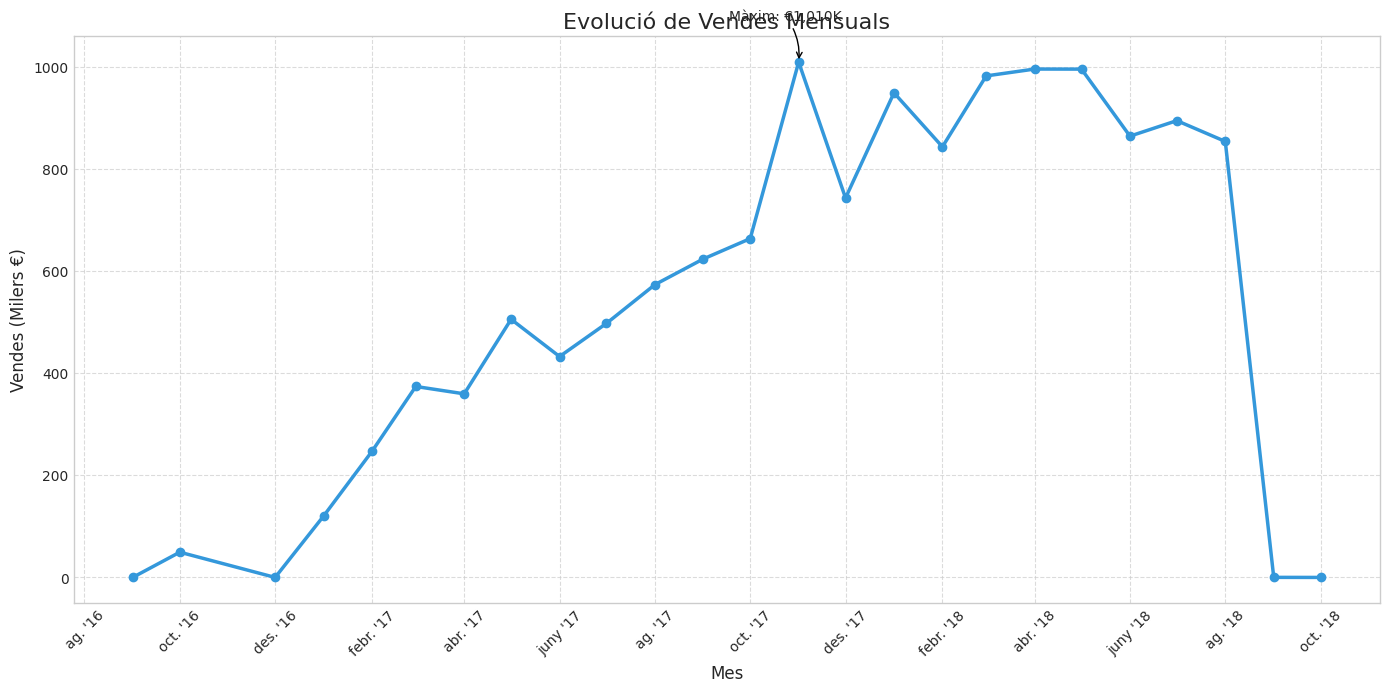

✅ Anàlisi de tendència de vendes mensuals completat.


In [ ]:
# ======================================================================
# 1. TENDÈNCIA DE VENDES MENSUALS
# ======================================================================

def plot_tendencia_vendes(df):
    """Visualitza l'evolució mensual de les vendes"""
    # Preparar dades
    df = df.copy()
    df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
    df['any_mes'] = df['order_purchase_timestamp'].dt.to_period('M').dt.to_timestamp()
    
    vendes_mensuals = df.groupby('any_mes').agg(
        vendes=('price', 'sum'),
        comandes=('order_id', 'nunique')
    ).reset_index()
    
    # Crear gràfic
    plt.figure(figsize=(14, 7))
    plt.plot(vendes_mensuals['any_mes'], vendes_mensuals['vendes'] / 1000, 
             linewidth=2.5, marker='o', color='#3498db')
    
    # Configuració del gràfic
    plt.title('Evolució de Vendes Mensuals', fontsize=16)
    plt.ylabel('Vendes (Milers R$)', fontsize=12)
    plt.xlabel('Mes', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Format de dates amb noms de mesos en català
    plt.gca().xaxis.set_major_formatter(DateFormatter("%b '%y"))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Destacar punt màxim
    max_idx = vendes_mensuals['vendes'].idxmax()
    plt.annotate(f"Màxim: R${vendes_mensuals.loc[max_idx, 'vendes']/1000:,.0f}K",
                 xy=(vendes_mensuals.loc[max_idx, 'any_mes'], vendes_mensuals.loc[max_idx, 'vendes']/1000),
                 xytext=(-50, 30), textcoords='offset points',
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.2'))
    
    plt.show()
    
    return vendes_mensuals
# Executar anàlisis directament sobre df_final
print("⏳ Iniciant anàlisi de dades...")

# 1. Tendència de vendes mensuals
vendes_mensuals = plot_tendencia_vendes(df_final)
print("✅ Anàlisi de tendència de vendes mensuals completat.")

C:\Users\PC\AppData\Local\Temp\ipykernel_5752\3044723445.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  categoria_metrics = df.groupby('categoria_catala').agg(
C:\Users\PC\AppData\Local\Temp\ipykernel_5752\3044723445.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


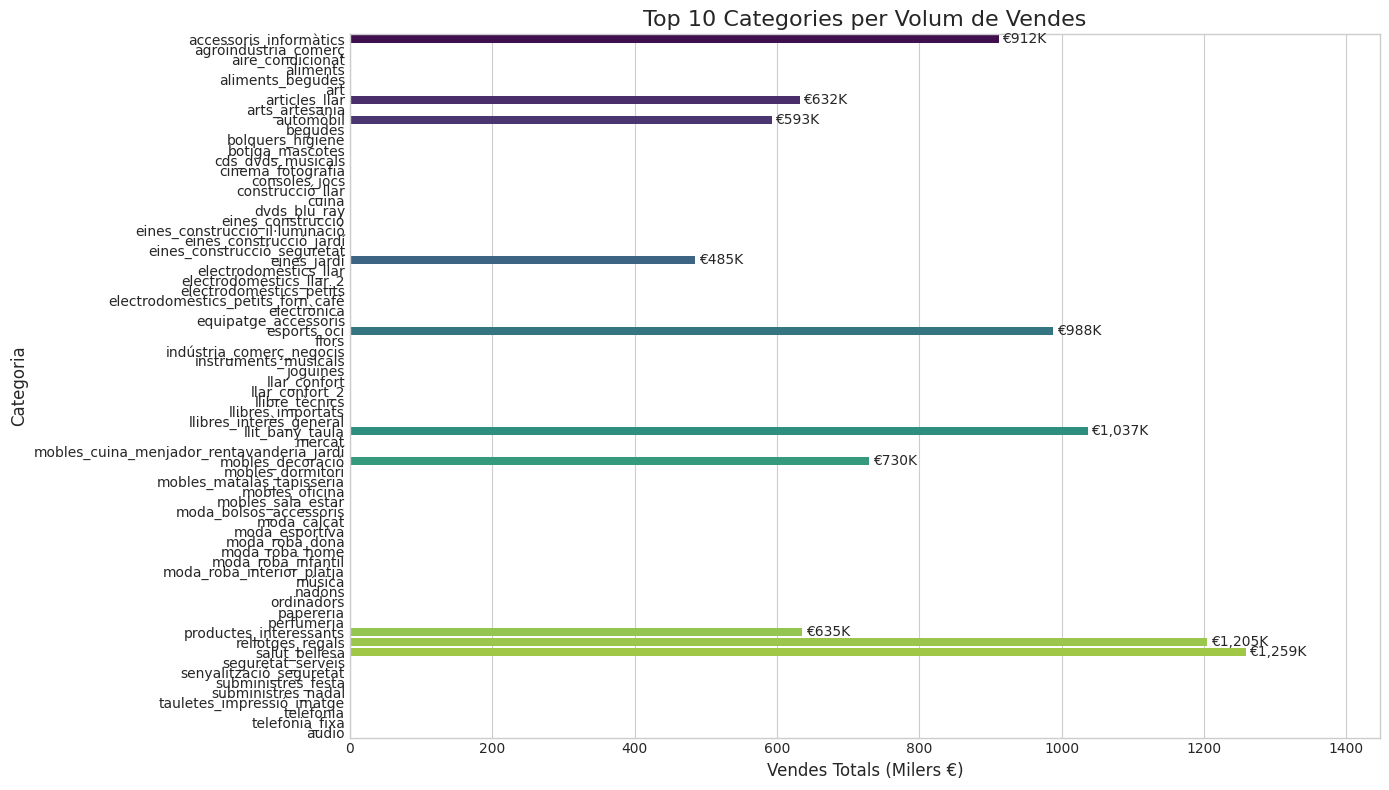

✅ Anàlisi de les 10 categories amb més vendes completat.


In [ ]:
# ======================================================================
# 2. TOP 10 CATEGORIES PER VOLUM
# ======================================================================

def plot_top_categories(df):
    """Visualitza les 10 categories amb més vendes"""
    # Assegurar que 'price' és numèric
    df['price'] = pd.to_numeric(df['price'], errors='coerce')
    
    # Agregar dades per categoria
    categoria_metrics = df.groupby('categoria_catala').agg(
        vendes_totals=('price', 'sum'),
        comandes_totals=('order_id', 'nunique'),
        productes_venduts=('product_id', 'count'),
        mitjana_preu=('price', 'mean'),
        mitjana_quantitat=('order_item_id', 'mean')
    ).reset_index()
    
    # Convertir a numèric per si hi ha problemes
    categoria_metrics['vendes_totals'] = pd.to_numeric(categoria_metrics['vendes_totals'], errors='coerce')
    
    # Top 10 per vendes
    top_categories = categoria_metrics.nlargest(10, 'vendes_totals')
    
    # Crear columna auxiliar per al gràfic
    top_categories['vendes_milers'] = top_categories['vendes_totals'] / 1000
    
    # Crear gràfic
    plt.figure(figsize=(14, 8))
    ax = sns.barplot(
        x='vendes_milers', 
        y='categoria_catala', 
        data=top_categories,
        palette="viridis"
    )
    
    # Afegir etiquetes
    for p in ax.patches:
        width = p.get_width()
        ax.text(width + 5, p.get_y() + p.get_height()/2, f'R${width:,.0f}K', 
                ha='left', va='center', fontsize=10)
    
    # Configuració
    plt.title('Top 10 Categories per Volum de Vendes', fontsize=16)
    plt.xlabel('Vendes Totals (Milers R$)', fontsize=12)
    plt.ylabel('Categoria', fontsize=12)
    plt.xlim(0, top_categories['vendes_milers'].max() * 1.15)
    plt.tight_layout()
    plt.show()
    
    return top_categories
# 2. Top 10 categories
top_categories = plot_top_categories(df_final)
print("✅ Anàlisi de les 10 categories amb més vendes completat.")

⏳ Generant mapa de calor (trams de 2 hores)...
✅ Mapa de calor guardat com a 'vendes_heatmap_trams.png'


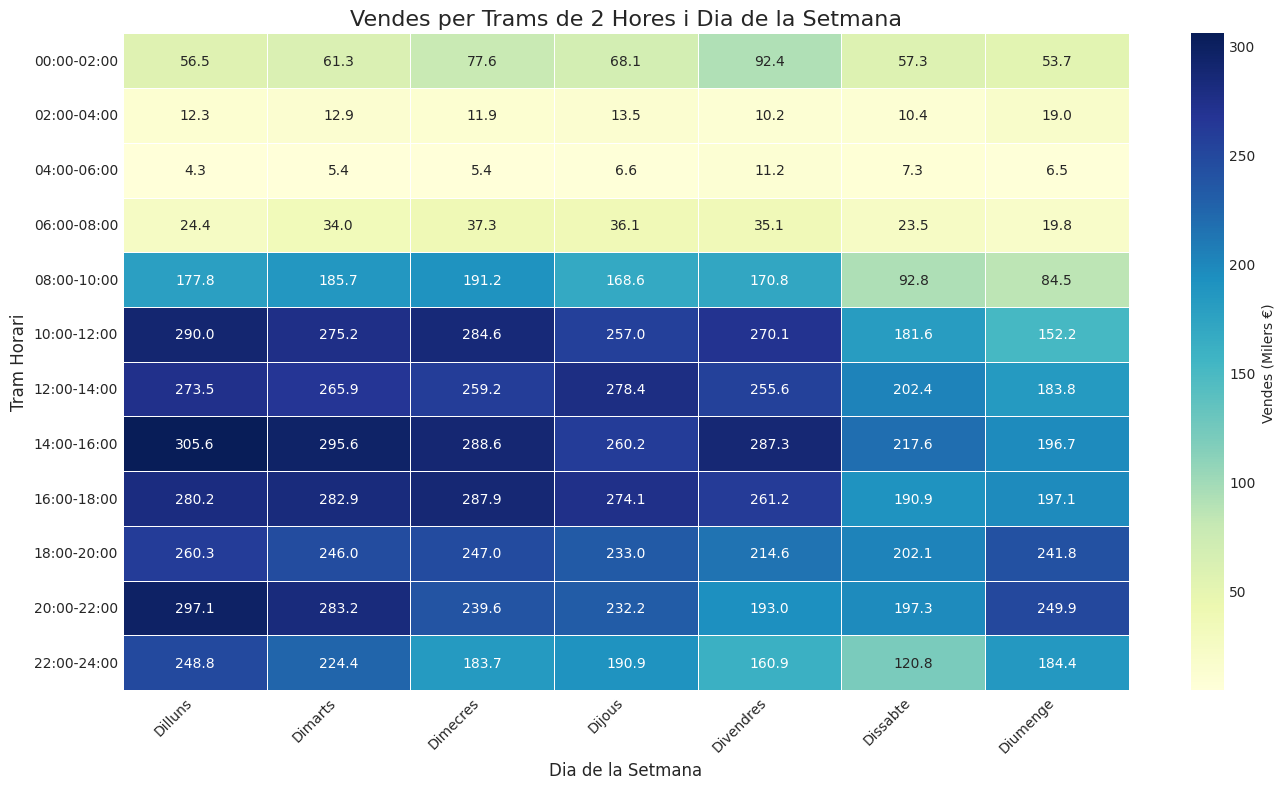

In [ ]:
# ======================================================================
# 3. MAPA DE CALOR DE VENDES PER TRAMS DE 2 HORES (Versió Millorada)
# ======================================================================

def plot_heatmap_vendes_agrupat(df):
    """Visualitza un mapa de calor de vendes per trams de 2 hores i dia"""
    print("⏳ Generant mapa de calor (trams de 2 hores)...")
    
    # Assegurar que el preu és numèric
    df = df.copy()
    df['price'] = pd.to_numeric(df['price'], errors='coerce')
    
    # Processament de dades
    df['hora'] = df['order_purchase_timestamp'].dt.hour
    df['dia_cat'] = df['order_purchase_timestamp'].dt.day_name().map(DIES_SETMANA_CATALA)
    
    # Agrupar hores en trams de 2 hores
    bins = list(range(0, 25, 2))  # 0, 2, 4, ..., 24
    labels = [f"{i:02d}:00-{i+2:02d}:00" for i in range(0, 24, 2)]
    df['tram_hores'] = pd.cut(df['hora'], bins=bins, labels=labels, right=False)
    
    # Agregació
    heatmap_data = (
        df.groupby(['tram_hores', 'dia_cat'], observed=True)['price']
        .sum()
        .unstack(fill_value=0)
        .reindex(columns=DIES_ORDRE, index=labels, fill_value=0)
        / 1000  # Convertir a milers d'euros
    )
    
    # Validació
    if heatmap_data.sum().sum() == 0:
        print("⚠️ Avís: No s'han trobat dades de vendes")
        return None

    # Configuració del gràfic
    plt.figure(figsize=(14, 8))
    ax = sns.heatmap(
        heatmap_data,
        cmap="YlGnBu",
        annot=True,
        fmt=".1f",
        linewidths=0.5,
        cbar_kws={'label': 'Vendes (Milers R$)'}
    )
    
    # Personalització
    ax.set_title('Vendes per Trams de 2 Hores i Dia de la Setmana', fontsize=16)
    ax.set_xlabel('Dia de la Setmana', fontsize=12)
    ax.set_ylabel('Tram Horari', fontsize=12)
    ax.set_xticklabels(DIES_ORDRE, rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig('vendes_heatmap_trams.png', dpi=300, bbox_inches='tight')
    print("✅ Mapa de calor guardat com a 'vendes_heatmap_trams.png'")
    plt.show()
    
    return heatmap_data

# Execució principal
if __name__ == "__main__":
    result = plot_heatmap_vendes_agrupat(df_final)
    plt.show()

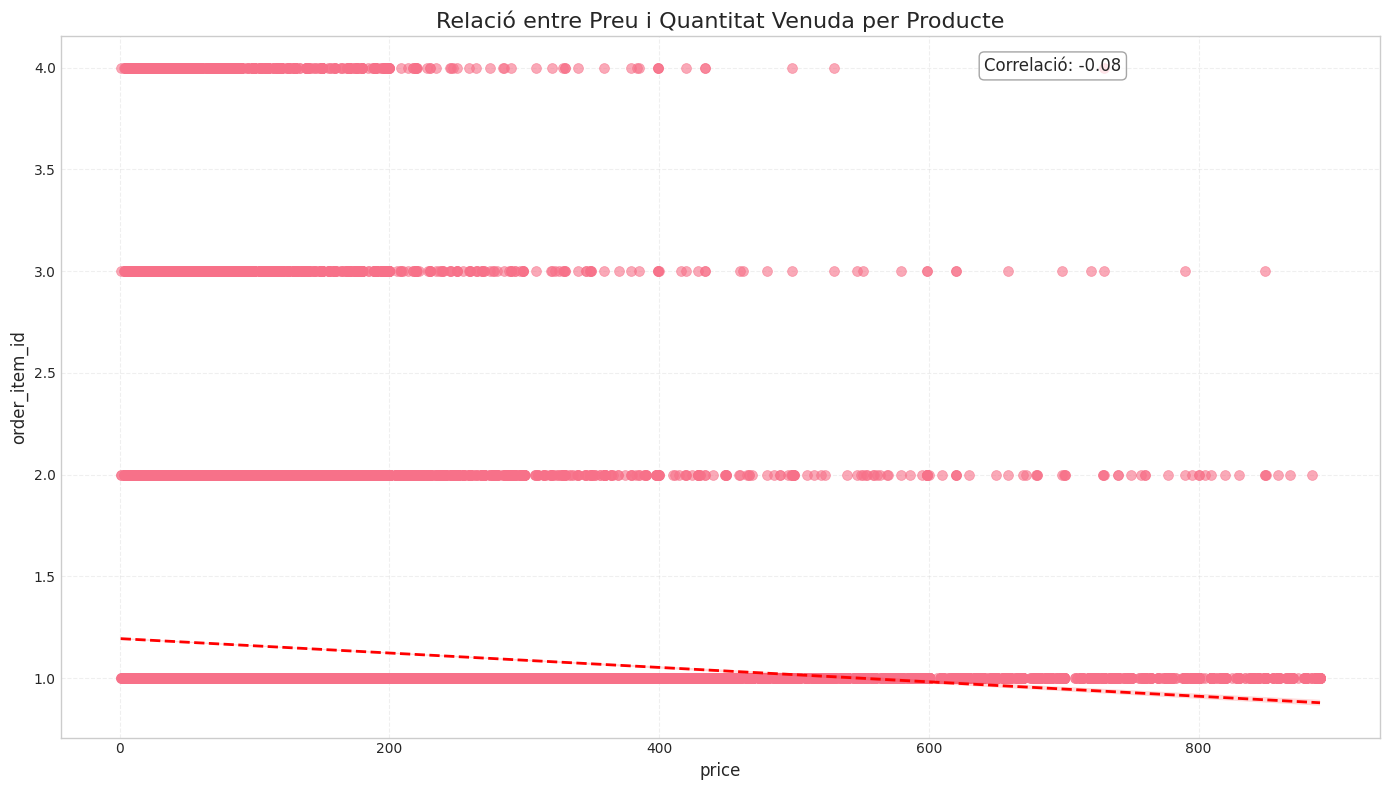

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,freight_value,categoria_catala,any,mes,setmana,dia_any,dia_setmana,hora,periode_mensual,mes_nom
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,8.72,articles_llar,2017,10,40,275,Monday,10,2017-10,Octubre
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,22.76,perfumeria,2018,7,30,205,Tuesday,20,2018-07,Juliol
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,19.22,automòbil,2018,8,32,220,Wednesday,8,2018-08,Agost
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,...,27.20,botiga_mascotes,2017,11,46,322,Saturday,19,2017-11,Novembre
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,8.72,papereria,2018,2,7,44,Tuesday,21,2018-02,Febrer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113420,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,da62f9e57a76d978d02ab5362c509660,11722,...,20.10,nadons,2018,2,6,37,Tuesday,12,2018-02,Febrer
113421,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,737520a9aad80b3fbbdad19b66b37b30,45920,...,65.02,electrodomèstics_llar_2,2017,8,34,239,Sunday,14,2017-08,Agost
113422,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,...,40.59,accessoris_informàtics,2018,1,2,8,Monday,21,2018-01,Gener
113423,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,...,40.59,accessoris_informàtics,2018,1,2,8,Monday,21,2018-01,Gener


In [ ]:
# ======================================================================
# 4. RELACIÓ PREU-QUANTITAT VENUDA
# ======================================================================

def plot_relacio_preu_quantitat(df):
    """Visualitza la relació entre preu i quantitat venuda"""
    df = df.copy()
    
    # Convertir a numèric (afegit per seguretat)
    df['price'] = pd.to_numeric(df['price'], errors='coerce')
    df['order_item_id'] = pd.to_numeric(df['order_item_id'], errors='coerce')
    
    # Filtrar outliers - versió optimitzada
    q_price = df['price'].quantile(0.99)
    q_quantity = df['order_item_id'].quantile(0.99)
    relacio_data = df[
        (df['price'] <= q_price) & 
        (df['order_item_id'] <= q_quantity)
    ]
    
    # Crear gràfic
    plt.figure(figsize=(14, 8))
    ax = sns.scatterplot(
        x='price', 
        y='order_item_id', 
        data=relacio_data,
        alpha=0.6,
        edgecolor=None,
        s=50  # Mida dels punts
    )
    
    # Configuració
    plt.title('Relació entre Preu i Quantitat Venuda per Producte', fontsize=16)
    plt.xlabel('Preu del Producte (R$)', fontsize=12)
    plt.ylabel('Quantitat Venuda per Comanda', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.3)
    
    # Afegir línia de tendència - versió optimitzada
    sns.regplot(
        x='price', 
        y='order_item_id', 
        data=relacio_data,
        scatter=False, 
        color='red',
        line_kws={"linewidth": 2, "linestyle": "--"}
    )
    
    # Afegir estadístics al gràfic
    corr = relacio_data[['price', 'order_item_id']].corr().iloc[0,1]
    plt.annotate(f"Correlació: {corr:.2f}", 
                 xy=(0.7, 0.95), 
                 xycoords='axes fraction',
                 fontsize=12,
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.7))
    
    plt.tight_layout()
    plt.show()
    
    return relacio_data

plot_relacio_preu_quantitat(df_final)

In [ ]:
# ======================================================================
# 5. ANÀLISI D'ESTACIONALITAT PER CATEGORIA
# ======================================================================

def plot_estacionalitat_categoria(categoria, df):
    """Visualitza l'estacionalitat per una categoria específica"""
    # Filtrar per categoria
    df = df.copy()
    df_cat = df[df['categoria_catala'] == categoria].copy()
    
    if df_cat.empty:
        print(f"⚠️ Categoria '{categoria}' no trobada")
        return
    
    # Convertir data
    df_cat['order_purchase_timestamp'] = pd.to_datetime(df_cat['order_purchase_timestamp'])
    
    # Agregar dades mensuals
    df_agregat = (
        df_cat.groupby([
            pd.Grouper(key='order_purchase_timestamp', freq='M')
        ])
        .agg(ventes=('price', 'sum'))
        .reset_index()
    )
    
    # Configuració del gràfic
    plt.figure(figsize=(14, 8))
    
    # Evolució temporal
    plt.subplot(2, 1, 1)
    plt.plot(
        df_agregat['order_purchase_timestamp'], 
        df_agregat['ventes'] / 1000,
        color='#3498db',
        linewidth=2.5
    )
    plt.title(f'Evolució Temporal: {categoria.replace("_", " ").title()}', fontsize=14)
    plt.ylabel('Vendes (Milers R$)')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Format de dates
    plt.gca().xaxis.set_major_formatter(DateFormatter("%b '%y"))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    
    # Estacionalitat mensual
    plt.subplot(2, 1, 2)
    df_agregat['mes'] = df_agregat['order_purchase_timestamp'].dt.month
    df_mensual = df_agregat.groupby('mes')['ventes'].mean().reset_index()
    
    plt.bar(
        df_mensual['mes'],
        df_mensual['ventes'] / 1000,
        color='#2ecc71',
        alpha=0.8
    )
    
    plt.title(f'Estacionalitat Mensual Mitjana: {categoria.replace("_", " ").title()}', fontsize=14)
    plt.xlabel('Mes')
    plt.ylabel('Vendes Mitjanes (Milers R$)')
    
    # Configurar eix X amb noms de mesos en català
    plt.xticks(range(1, 13), MESOS_CATALA, rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Informació estadística
    print(f"\n📊 Estadístiques per a {categoria.replace('_', ' ').title()}:")
    print(f"- Vendes totals: R${df_agregat['ventes'].sum()/1000:,.1f} milers")
    print(f"- Vendes mitjanes mensuals: R${df_agregat['ventes'].mean()/1000:,.1f} milers")
    
    # Obtenir mesos amb màximes i mínimes vendes
    if not df_mensual.empty:
        mes_max = df_mensual.loc[df_mensual['ventes'].idxmax(), 'mes']
        mes_min = df_mensual.loc[df_mensual['ventes'].idxmin(), 'mes']
        
        nom_mes_max = MESOS_CATALA[mes_max - 1] if 1 <= mes_max <= 12 else f"Mes {mes_max}"
        nom_mes_min = MESOS_CATALA[mes_min - 1] if 1 <= mes_min <= 12 else f"Mes {mes_min}"
        
        print(f"- Mes amb màximes vendes: {nom_mes_max}")
        print(f"- Mes amb mínimes vendes: {nom_mes_min}")
    else:
        print("- No hi ha dades suficients per determinar estacionalitat")
    
    return df_agregat



C:\Users\PC\AppData\Local\Temp\ipykernel_5752\2635647433.py:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.Grouper(key='order_purchase_timestamp', freq='M')


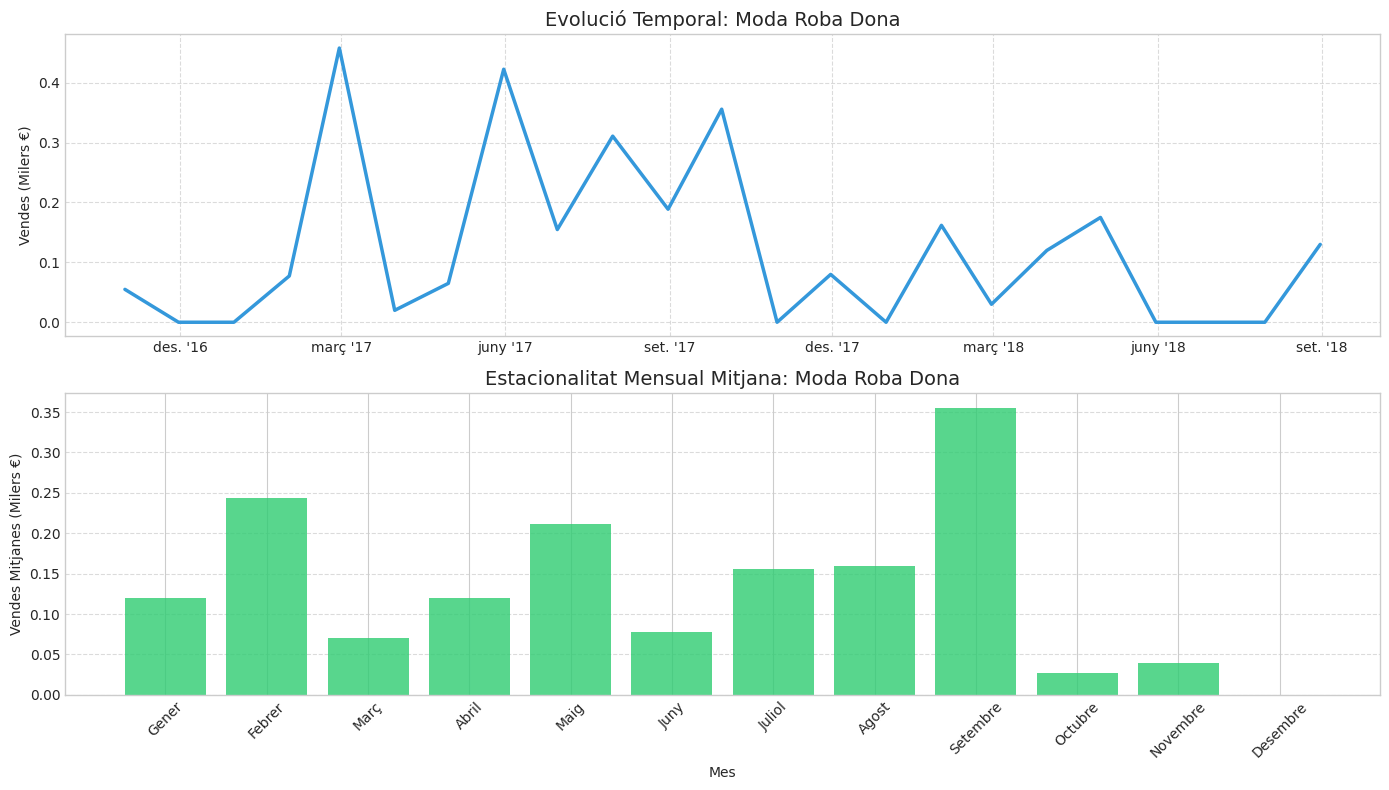


📊 Estadístiques per a Moda Roba Dona:
- Vendes totals: €2.8 milers
- Vendes mitjanes mensuals: €0.1 milers
- Mes amb màximes vendes: Setembre
- Mes amb mínimes vendes: Desembre


In [80]:

# 5. Anàlisi d'estacionalitat per categoria (exemple amb una categoria)
categoria_exemple = 'moda_roba_dona'  # Canvia per la categoria que desitgis
df_estacionalitat = plot_estacionalitat_categoria(categoria_exemple, df_final)

C:\Users\PC\AppData\Local\Temp\ipykernel_5752\1007589708.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agregat.groupby('categoria_catala')['price']


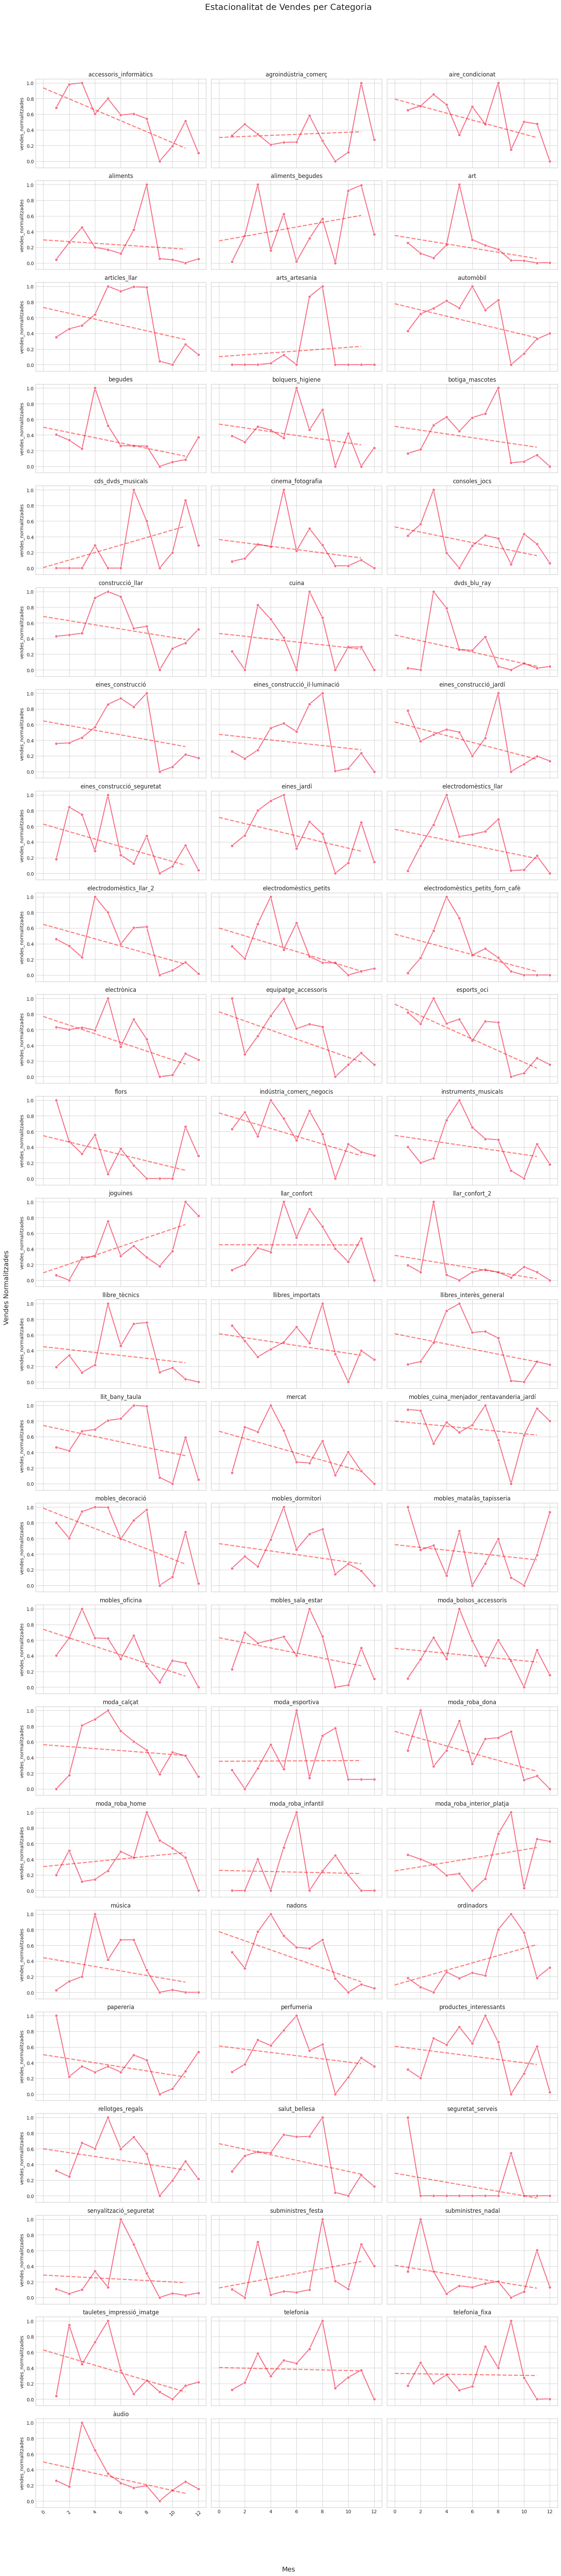

In [82]:
# ======================================================================
# 5. ESTACIONALITAT PER CATEGORIA (Totes les categories)
# ======================================================================


def plot_estacionalitat_totes_categories(df):
    """Visualitza l'estacionalitat de vendes per a totes les categories"""
    # 1. Preparació de dades
    df_estacionalitat = df.copy()
    
    # Agregar vendes mensuals per categoria
    df_agregat = (
        df_estacionalitat.groupby(['categoria_catala', 'mes'], observed=False)['price']
        .sum()
        .reset_index()
    )
    
    # Normalitzar per millor comparació
    df_agregat['vendes_normalitzades'] = (
        df_agregat.groupby('categoria_catala')['price']
        .transform(lambda x: (x - x.min()) / (x.max() - x.min() + 1e-9))  # +1e-9 evita divisió per zero
    )
    
    # 2. Configuració del gràfic
    categories = df_agregat['categoria_catala'].unique()
    n_categories = len(categories)
    
    # Calcular estructura de grid
    n_cols = 3
    n_rows = (n_categories + n_cols - 1) // n_cols
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, n_rows*3), sharex=True, sharey=True)
    fig.suptitle('Estacionalitat de Vendes per Categoria', fontsize=18, y=1.02)
    
    # 3. Generar un gràfic per categoria
    for i, categoria in enumerate(categories):
        row = i // n_cols
        col = i % n_cols
        
        # Seleccionar eix actual
        if n_rows > 1:
            ax = axs[row, col]
        elif n_cols > 1:
            ax = axs[col]
        else:
            ax = axs
        
        # Filtrar dades per categoria
        df_categoria = df_agregat[df_agregat['categoria_catala'] == categoria].sort_values('mes')
        
        # Crear gràfic de línia
        sns.lineplot(
            x='mes', 
            y='vendes_normalitzades', 
            data=df_categoria,
            ax=ax,
            marker='o',
            linewidth=2
        )
        
        # Personalitzar
        ax.set_title(categoria, fontsize=12)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.tick_params(axis='x', rotation=45)
        
        # Afegir línia de tendència (corregit)
        if not df_categoria.empty:
            x_values = np.arange(len(df_categoria))
            sns.regplot(
                x=x_values, 
                y='vendes_normalitzades', 
                data=df_categoria,
                ax=ax,
                scatter=False,
                ci=None,
                line_kws={'linestyle': '--', 'color': 'red', 'alpha': 0.5}
            )
    
    # 4. Ajustar layout
    plt.tight_layout()
    
    # Afegir etiquetes globals
    fig.text(0.5, -0.02, 'Mes', ha='center', fontsize=14)
    fig.text(-0.02, 0.5, 'Vendes Normalitzades', va='center', rotation='vertical', fontsize=14)
    
    # 5. Guardar i mostrar
    plt.savefig('estacionalitat_categories.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return df_agregat

# Executar l'anàlisi
df_estacionalitat = plot_estacionalitat_totes_categories(df_final)

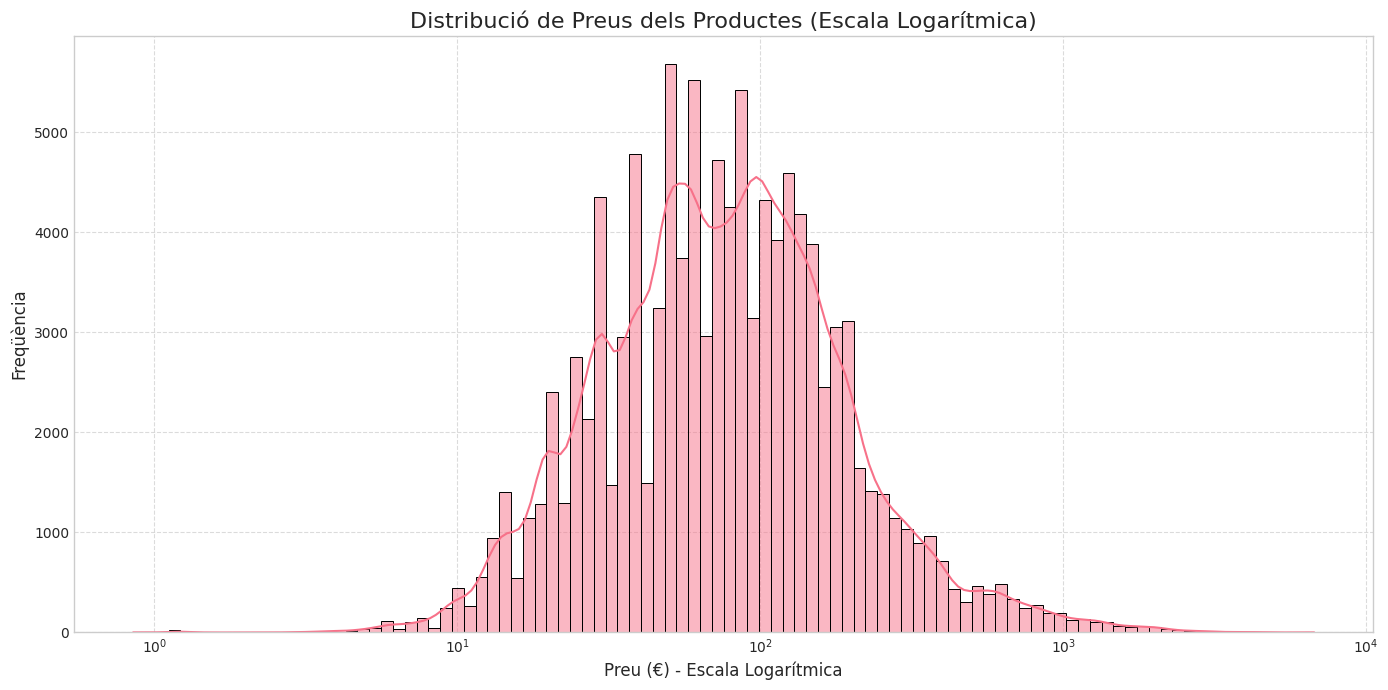

In [ ]:
# ======================================================================
# 6. ANÀLISI COMPLEMENTARI: DISTRIBUCIÓ DE PREUS
# ======================================================================

def plot_distribucio_preus(df):
    """Visualitza la distribució de preus dels productes"""
    plt.figure(figsize=(14, 7))
    sns.histplot(
        df['price'], 
        bins=100, 
        kde=True,
        log_scale=True
    )
    
    # Configuració
    plt.title('Distribució de Preus dels Productes (Escala Logarítmica)', fontsize=16)
    plt.xlabel('Preu (R$) - Escala Logarítmica', fontsize=12)
    plt.ylabel('Freqüència', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# 6. Distribució de preus
plot_distribucio_preus(df_final)

In [ ]:




# ======================================================================
# EXECUCIÓ PRINCIPAL
# ======================================================================

# Assegura't que tens el DataFrame df_final a memòria
# (del procés de fusió i traducció anterior)

# Executar anàlisis directament sobre df_final
print("⏳ Iniciant anàlisi de dades...")

# 1. Tendència de vendes mensuals
vendes_mensuals = plot_tendencia_vendes(df_final)

# 2. Top 10 categories
top_categories = plot_top_categories(df_final)

# 3. Mapa de calor per hora i dia
def plot_heatmap_vendes(df):
    df = df.copy()
    df['price'] = pd.to_numeric(df['price'], errors='coerce')

# 4. Relació preu-quantitat
def plot_relacio_preu_quantitat(df):
    df = df.copy()
    df['price'] = pd.to_numeric(df['price'], errors='coerce')
    df['order_item_id'] = pd.to_numeric(df['order_item_id'], errors='coerce')

# 5. Anàlisi d'estacionalitat per categoria (exemple amb una categoria)
categoria_exemple = 'moda_roba_dona'  # Canvia per la categoria que desitgis
df_estacionalitat = plot_estacionalitat_categoria(categoria_exemple, df_final)

# 6. Distribució de preus
plot_distribucio_preus(df_final)

print("✅ Anàlisi completat amb èxit!")

In [ ]:
# ======================================================================
# 12. FEATURE ENGINEERING (CORREGIT)
# ======================================================================

print("\n" + "="*50)
print("ENGINYERIA DE CARACTERÍSTIQUES (FEATURE ENGINEERING)")

# 1. DIA DE LA SETMANA I FINAL DE SETMANA
# Convertim el dia de la setmana a numèric (0=Dilluns, 6=Diumenge)
df_final['dia_semana_num'] = df_final['dia_setmana'].cat.codes

# Creem l'indicador de cap de setmana
df_final['es_fin_de_semana'] = df_final['dia_semana_num'].isin([5, 6]).astype(np.int8)

# 2. LAG_7D (VENDES DE LA MATEIXA CATEGORIA FA 7 DIES)
# Assegurem que tenim la columna 'order_date'
if 'order_date' not in df_final.columns:
    df_final['order_date'] = df_final['order_purchase_timestamp'].dt.date

# Agregació diària per categoria
df_agregat = df_final.groupby(['categoria_catala', 'order_date'])['price'].sum().reset_index()
df_agregat.rename(columns={'price': 'vendes_diaries'}, inplace=True)

# Calculem el lag de 7 dies
df_agregat.sort_values(['categoria_catala', 'order_date'], inplace=True)
df_agregat['lag_7d'] = df_agregat.groupby('categoria_catala')['vendes_diaries'].shift(7)

# Fem merge amb el dataframe original - CORRECCIÓ CLAU
# Utilitzem suffixes per evitar conflictes de noms
df_final = df_final.merge(
    df_agregat[['categoria_catala', 'order_date', 'lag_7d']],
    on=['categoria_catala', 'order_date'],
    how='left',
    suffixes=('', '_agregat')
)

# 3. PREU MITJÀ PER CATEGORIA
df_final['avg_price_category'] = df_final.groupby('categoria_catala')['price'].transform('mean')

# 4. INDICADOR DE FESTIU 
# Obtenim anys únics
years = df_final['order_purchase_timestamp'].dt.year.unique().tolist()
br_holidays = holidays.BR(years=years)

# Funció per verificar festius
def es_festivo(date):
    return 1 if date in br_holidays else 0

# Apliquem la funció
df_final['festivo'] = df_final['order_date'].apply(es_festivo).astype(np.int8)

# 5. OPTIMITZACIÓ DE MEMÒRIA 
# Verifiquem que la columna existeix abans de convertir
if 'lag_7d' in df_final.columns:
    df_final['lag_7d'] = df_final['lag_7d'].astype(np.float32)
else:
    print("⚠️ ATENCIÓ: Columna 'lag_7d' no creada. Reviseu el merge.")

df_final['dia_semana_num'] = df_final['dia_semana_num'].astype(np.int8)
df_final['avg_price_category'] = df_final['avg_price_category'].astype(np.float32)

# 6. VERIFICACIÓ
print("\n" + "="*50)
print("RESUM DE FEATURE ENGINEERING")
print(f"- Dies de la setmana numèrics: {df_final['dia_semana_num'].min()} a {df_final['dia_semana_num'].max()}")
print(f"- Fin de setmana: {df_final['es_fin_de_semana'].sum()} registres")
print(f"- Valors festius: {df_final['festivo'].sum()} dies festius")

# Verifiquem específicament lag_7d
if 'lag_7d' in df_final.columns:
    print(f"- Valors nuls en lag_7d: {df_final['lag_7d'].isnull().sum()} (esperat en primers 7 dies)")
else:
    print("⚠️ 'lag_7d' no present al DataFrame")

print(f"- Preu mitjà per categoria: {df_final['avg_price_category'].mean():.2f}R$")

# Mostrem mostra de les noves característiques
print("\nMostra de característiques enginyerades:")
print(df_final[['order_date', 'categoria_catala', 'dia_semana_num', 
                'es_fin_de_semana', 'avg_price_category', 'festivo']].head(3))
if 'lag_7d' in df_final.columns:
    print("lag_7d inclòs")
else:
    print("lag_7d NO inclòs")


ENGINYERIA DE CARACTERÍSTIQUES (FEATURE ENGINEERING)

RESUM DE FEATURE ENGINEERING
- Dies de la setmana numèrics: 0 a 6
- Fin de setmana: 25730 registres
- Valors festius: 1717 dies festius
- Valors nuls en lag_7d: 2485 (esperat en primers 7 dies)
- Preu mitjà per categoria: 120.76€

Mostra de característiques enginyerades:
   order_date categoria_catala  dia_semana_num  es_fin_de_semana  \
0  2017-10-02    articles_llar               0                 0   
1  2018-07-24       perfumeria               1                 0   
2  2018-08-08        automòbil               2                 0   

   avg_price_category  festivo  
0           90.788155        0  
1          116.737312        0  
2          139.957520        0  
lag_7d inclòs


C:\Users\PC\AppData\Local\Temp\ipykernel_5752\2450872950.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agregat = df_final.groupby(['categoria_catala', 'order_date'])['price'].sum().reset_index()
C:\Users\PC\AppData\Local\Temp\ipykernel_5752\2450872950.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agregat['lag_7d'] = df_agregat.groupby('categoria_catala')['vendes_diaries'].shift(7)
C:\Users\PC\AppData\Local\Temp\ipykernel_5752\2450872950.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain 


PREPARACIÓ PER A MODELAT PREDICTIU
📊 Mides dels conjunts:
- Entrenament: 89723 registres
- Prova: 21300 registres
- Característiques utilitzades: ['category_id', 'lag_7d', 'dia_semana_num', 'es_fin_de_semana', 'avg_price_category', 'festivo', 'mes']

ENTRENAMENT DEL MODEL XGBOOST
⏱ Temps d'entrenament: 1.03 segons

AVALUACIÓ DEL MODEL
⏱ Temps de predicció: 0.04 segons per 21300 registres
📈 Resultats globals:
- MAE: R$88.51
- MAE (% del preu mitjà): 72.42%
- RMSE: R$191.15
- Preu mitjà real: R$122.21

🔍 MAE per categoria (millors resultats):
               categoria        mae  mae_percent  n_registres  preu_mitja
54      bolquers_higiene  18.806517    37.469044           14   50.192142
30        mobles_oficina  69.179626    39.311668          189  175.977341
45                   art  35.646717    41.003269           67   86.936279
47      mobles_dormitori  68.403076    41.223572           31  165.931946
32          llar_confort  60.996346    44.872932           56  135.931259
57      

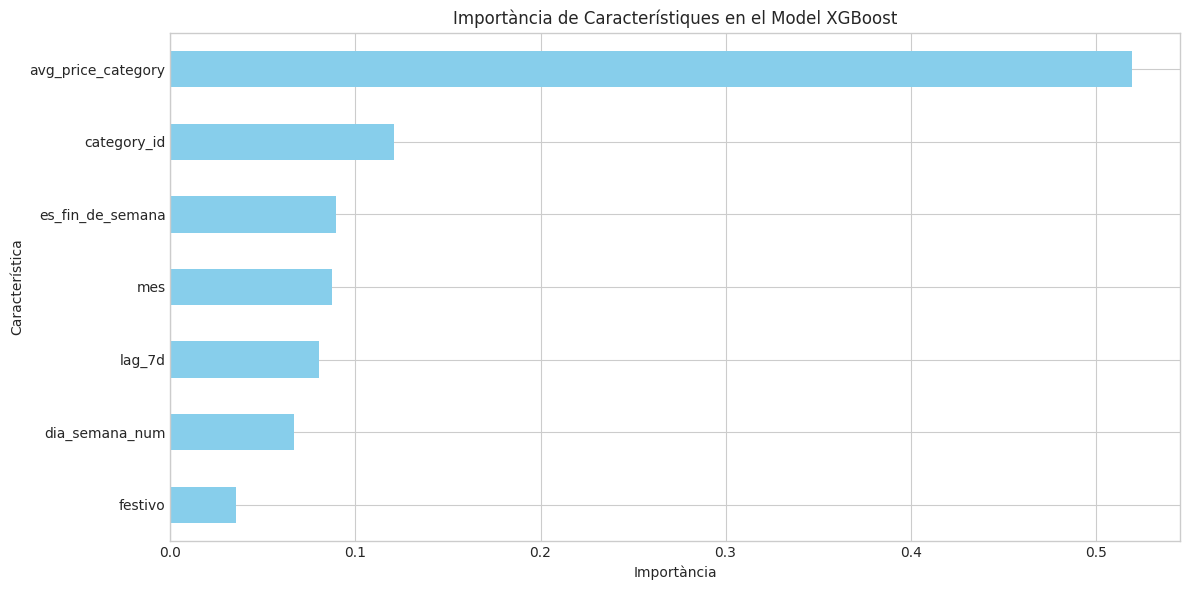

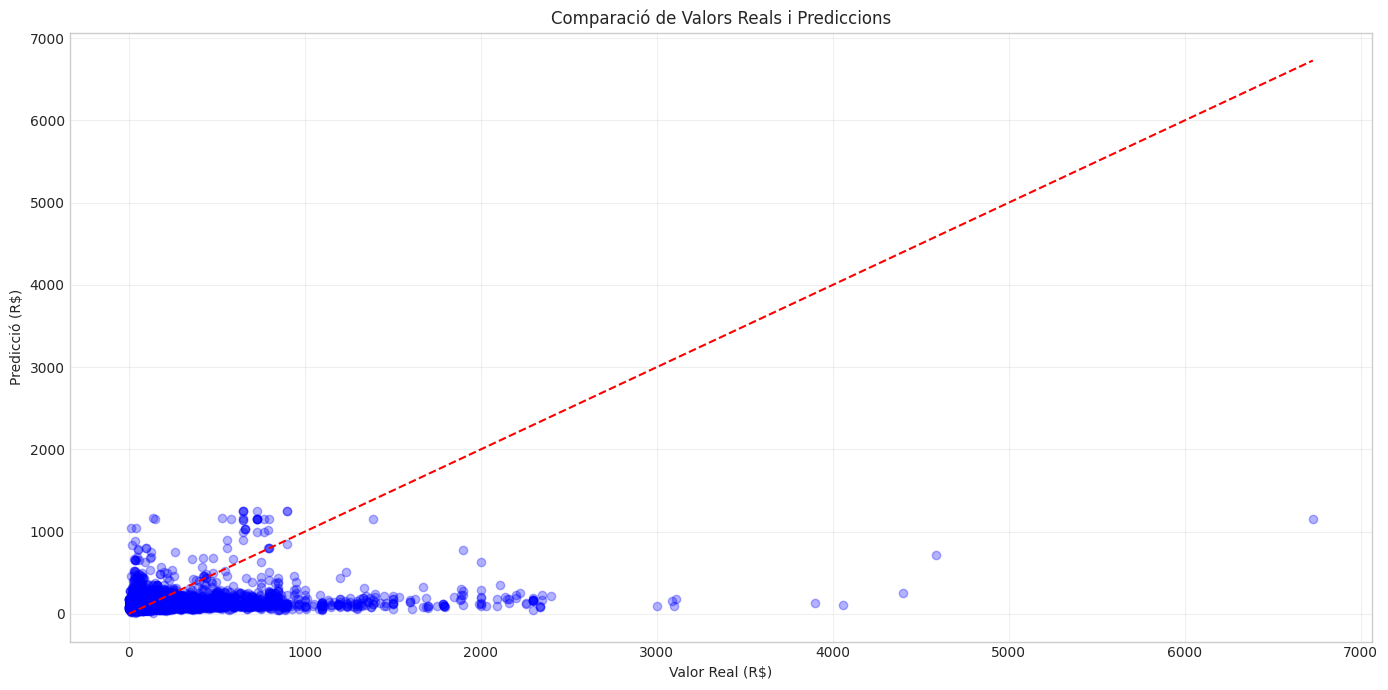

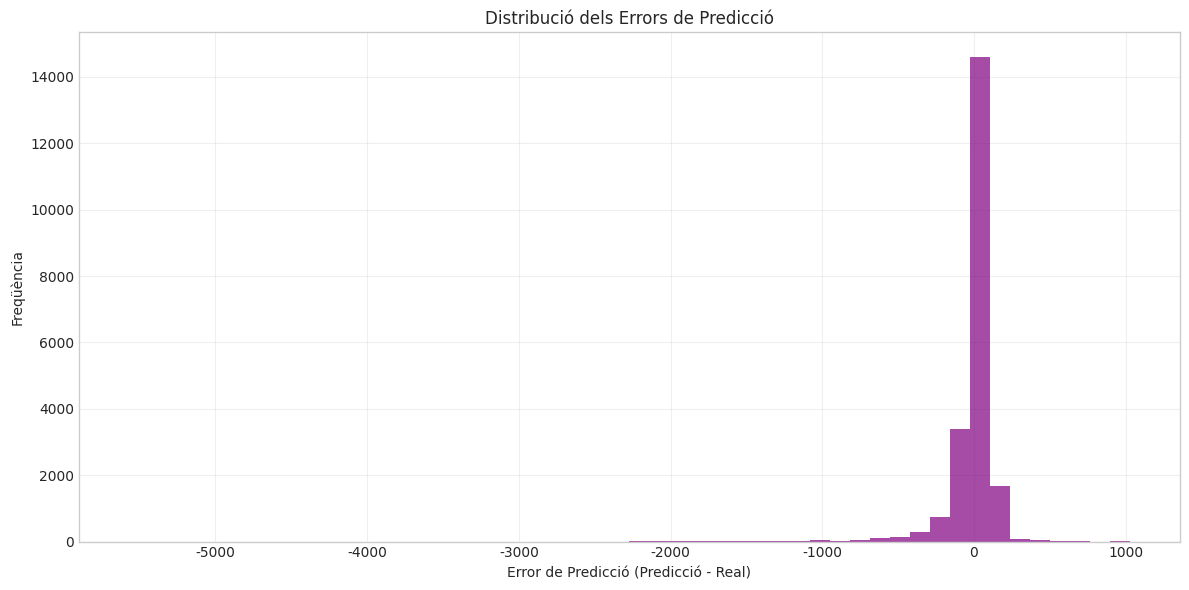


DESANT RESULTATS
✅ Model desat com a 'model_ventas_xgboost.pkl'
✅ Resultats per categoria desats a 'resultats_per_categoria.csv'
✅ Prediccions desades a 'prediccions.csv'

✅ PROCÉS DE MODELAT COMPLETAT AMB ÈXIT ✅


C:\Users\PC\AppData\Local\Temp\ipykernel_5752\3037756208.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['prediccio_price'] = preds


In [89]:
# ======================================================================
# 13. MODELAT PREDICTIU DE VENDES (AMB XGBOOST) - VERSIÓ COMPATIBLE
# ======================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
import joblib
import time

print("\n" + "="*50)
print("PREPARACIÓ PER A MODELAT PREDICTIU")

# 1. PREPARACIÓ DE DADES --------------------------------------------------
# Assegurem que no hi hagi valors nuls a les característiques
df_final = df_final.dropna(subset=['lag_7d', 'avg_price_category'])

# Codificar categories
le = LabelEncoder()
df_final['category_id'] = le.fit_transform(df_final['categoria_catala'])

# Definir conjunt de característiques
features = [
    'category_id', 
    'lag_7d', 
    'dia_semana_num',
    'es_fin_de_semana',
    'avg_price_category',
    'festivo',
    'mes'
]

# Definir data de tall
split_date = '2018-06-01'
df_train = df_final[df_final['order_purchase_timestamp'] < split_date]
df_test = df_final[df_final['order_purchase_timestamp'] >= split_date]

print(f"📊 Mides dels conjunts:")
print(f"- Entrenament: {len(df_train)} registres")
print(f"- Prova: {len(df_test)} registres")
print(f"- Característiques utilitzades: {features}")

# 2. ENTRENAMENT DEL MODEL ------------------------------------------------
print("\n" + "="*50)
print("ENTRENAMENT DEL MODEL XGBOOST")

# Configuració del model
model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Entrenament
start_time = time.time()
model.fit(df_train[features], df_train['price'])
training_time = time.time() - start_time
print(f"⏱ Temps d'entrenament: {training_time:.2f} segons")

# 3. AVALUACIÓ I PREDICCIÓ ------------------------------------------------
print("\n" + "="*50)
print("AVALUACIÓ DEL MODEL")

# Predicció
start_time = time.time()
preds = model.predict(df_test[features])
prediction_time = time.time() - start_time
print(f"⏱ Temps de predicció: {prediction_time:.2f} segons per {len(df_test)} registres")

# Mètriques
mae = mean_absolute_error(df_test['price'], preds)
rmse = np.sqrt(mean_squared_error(df_test['price'], preds))
mean_price = df_test['price'].mean()
mae_percent = (mae / mean_price) * 100

print(f"📈 Resultats globals:")
print(f"- MAE: R${mae:.2f}")
print(f"- MAE (% del preu mitjà): {mae_percent:.2f}%")
print(f"- RMSE: R${rmse:.2f}")
print(f"- Preu mitjà real: R${mean_price:.2f}")

# Resultats per categoria
resultats_per_categoria = []
for categoria in df_test['categoria_catala'].unique():
    mascara = df_test['categoria_catala'] == categoria
    if mascara.sum() > 10:  # Només per categories amb suficients dades
        preus_reals = df_test.loc[mascara, 'price']
        preds_cat = preds[mascara]
        mae_cat = mean_absolute_error(preus_reals, preds_cat)
        mean_price_cat = preus_reals.mean()
        mae_percent_cat = (mae_cat / mean_price_cat) * 100
        
        resultats_per_categoria.append({
            'categoria': categoria,
            'mae': mae_cat,
            'mae_percent': mae_percent_cat,
            'n_registres': mascara.sum(),
            'preu_mitja': mean_price_cat
        })

# Mostrar resultats per categoria
if resultats_per_categoria:
    df_resultats = pd.DataFrame(resultats_per_categoria).sort_values('mae_percent')
    print("\n🔍 MAE per categoria (millors resultats):")
    print(df_resultats.head(10))
    
    print("\n⚠️ MAE per categoria (pitjors resultats):")
    print(df_resultats.tail(10))
else:
    print("⚠️ No s'han pogut calcular resultats per categoria")

# 4. VISUALITZACIÓ DE RESULTATS --------------------------------------------
print("\n" + "="*50)
print("VISUALITZACIÓ DE RESULTATS")

# Importància de característiques
plt.figure(figsize=(12, 6))
feature_importances = pd.Series(model.feature_importances_, index=features)
feature_importances.sort_values().plot(kind='barh', color='skyblue')
plt.title('Importància de Característiques en el Model XGBoost')
plt.xlabel('Importància')
plt.ylabel('Característica')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

# Prediccions vs Reals
plt.figure(figsize=(14, 7))
plt.scatter(df_test['price'], preds, alpha=0.3, color='blue')
plt.plot([0, df_test['price'].max()], [0, df_test['price'].max()], '--r')
plt.xlabel('Valor Real (R$)')
plt.ylabel('Predicció (R$)')
plt.title('Comparació de Valors Reals i Prediccions')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('prediccions_vs_reals.png')
plt.show()

# Histograma d'errors
errors = preds - df_test['price']
plt.figure(figsize=(12, 6))
plt.hist(errors, bins=50, color='purple', alpha=0.7)
plt.xlabel('Error de Predicció (Predicció - Real)')
plt.ylabel('Freqüència')
plt.title('Distribució dels Errors de Predicció')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('distribucio_errors.png')
plt.show()

# 5. DESAR MODEL I RESULTATS -----------------------------------------------
print("\n" + "="*50)
print("DESANT RESULTATS")

# Desar model
joblib.dump(model, 'model_ventas_xgboost.pkl')
print("✅ Model desat com a 'model_ventas_xgboost.pkl'")

# Desar resultats per categoria
if 'df_resultats' in locals():
    df_resultats.to_csv('resultats_per_categoria.csv', index=False)
    print("✅ Resultats per categoria desats a 'resultats_per_categoria.csv'")

# Desar prediccions
df_test['prediccio_price'] = preds
df_test[['order_id', 'product_id', 'price', 'prediccio_price']].to_csv('prediccions.csv', index=False)
print("✅ Prediccions desades a 'prediccions.csv'")

print("\n" + "="*50)
print("✅ PROCÉS DE MODELAT COMPLETAT AMB ÈXIT ✅")


PREPARACIÓ PER A MODELAT PREDICTIU MILLORAT

ENTRENAMENT DE MODELS PER SEGMENT DE PREU

🔹 Entrenament per a segment: economic
- Registres entrenament: 57852
- Registres prova: 13336
⏱ Temps d'entrenament: 1.45 segons
📈 Resultats per a segment economic:
- MAE: R$21.05 (41.8% del preu mitjà)
- RMSE: R$26.73


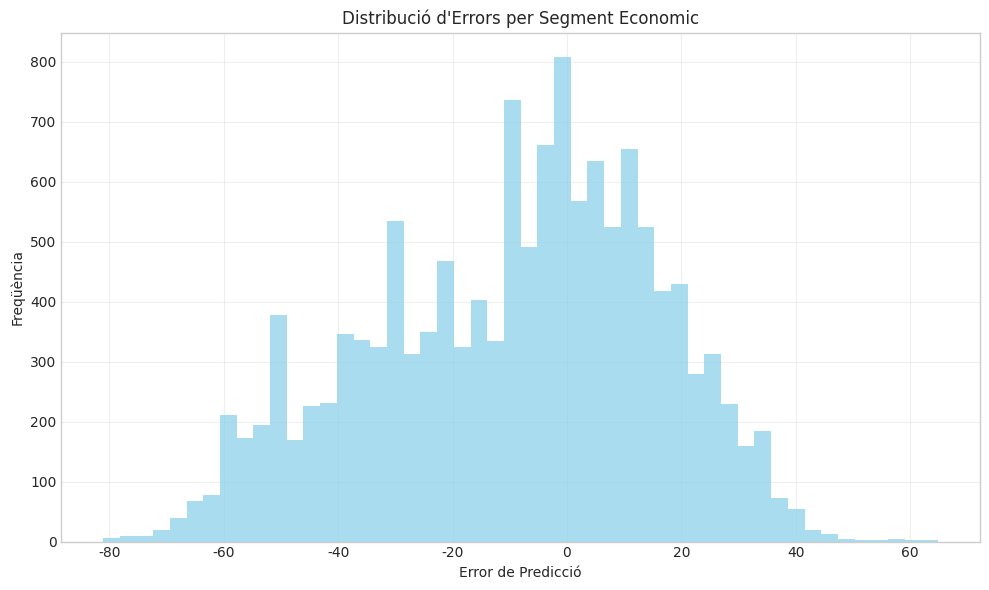


🔹 Entrenament per a segment: mitja
- Registres entrenament: 31209
- Registres prova: 7792
⏱ Temps d'entrenament: 0.75 segons
📈 Resultats per a segment mitja:
- MAE: R$83.84 (39.8% del preu mitjà)
- RMSE: R$143.65


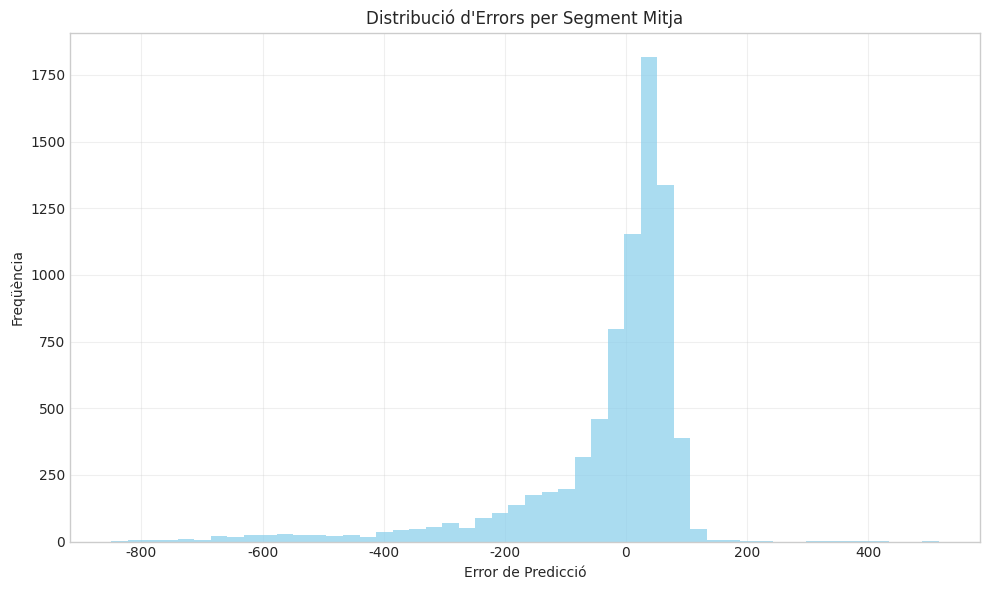


🔹 Entrenament per a segment: premium
- Registres entrenament: 662
- Registres prova: 172
⏱ Temps d'entrenament: 0.32 segons
📈 Resultats per a segment premium:
- MAE: R$470.21 (28.0% del preu mitjà)
- RMSE: R$794.41


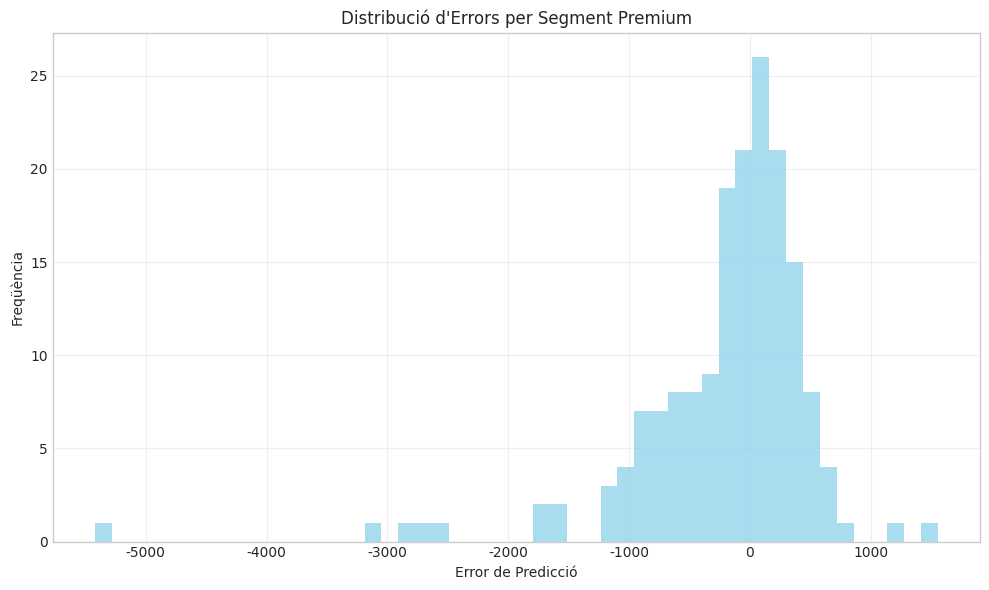


AVALUACIÓ GLOBAL DEL SISTEMA

🌍 RESULTATS GLOBALS:
- MAE Global: R$47.65 (39.0% del preu mitjà)
- RMSE Global: R$114.42

🔍 COMPARATIVA PER SEGMENTS:
- Economic: MAE=21.05 (41.8%), Registres prova=13336
- Mitja: MAE=83.84 (39.8%), Registres prova=7792
- Premium: MAE=470.21 (28.0%), Registres prova=172

VISUALITZACIÓ DE RESULTATS MILLORATS


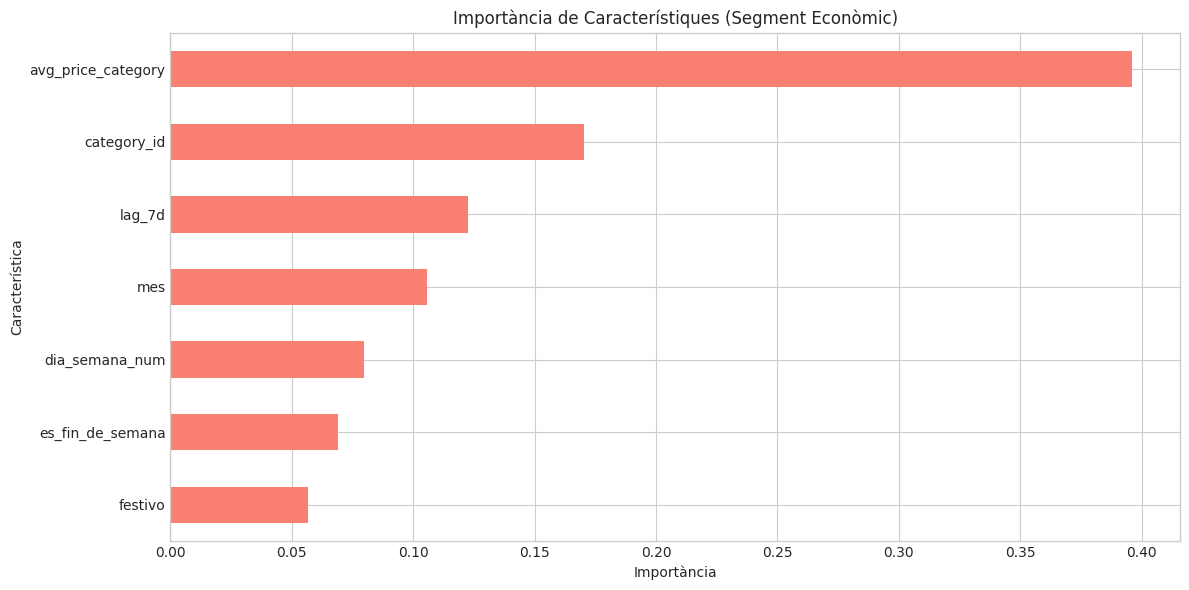

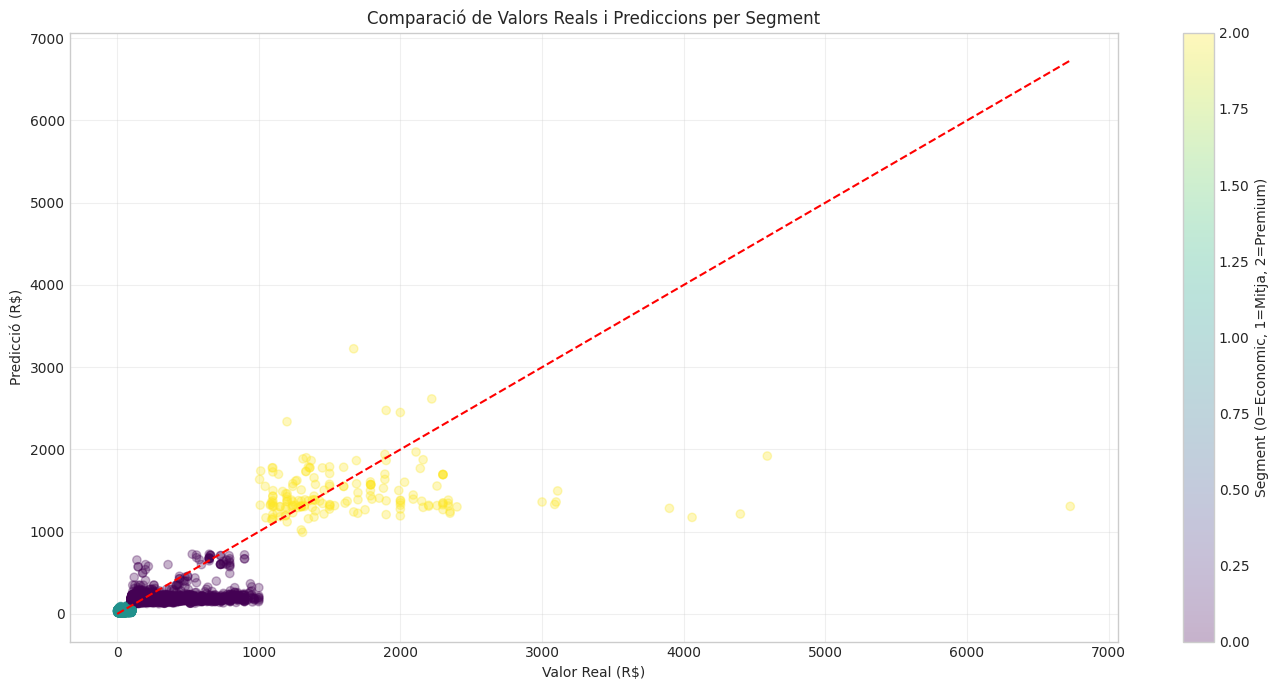


DESANT RESULTATS MILLORATS
✅ Model per a segment economic desat com a 'model_ventas_economic.pkl'
✅ Model per a segment mitja desat com a 'model_ventas_mitja.pkl'
✅ Model per a segment premium desat com a 'model_ventas_premium.pkl'
✅ Resultats per segment desats a 'resultats_per_segment.csv'
✅ Prediccions globals desades a 'prediccions_globals.csv'

✅ PROCÉS DE MODELAT MILLORAT COMPLETAT AMB ÈXIT ✅


In [90]:
# ======================================================================
# 13. MODELAT PREDICTIU DE VENDES - VERSIÓ MILLORADA
# ======================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder, QuantileTransformer
import joblib
import time
import warnings

# Desactivar warnings per a major claredat en l'execució
warnings.filterwarnings('ignore')

print("\n" + "="*50)
print("PREPARACIÓ PER A MODELAT PREDICTIU MILLORAT")

# 1. PREPARACIÓ DE DADES --------------------------------------------------
# Assegurem que no hi hagi valors nuls a les característiques
df_final = df_final.dropna(subset=['lag_7d', 'avg_price_category'])

# Codificar categories
le = LabelEncoder()
df_final['category_id'] = le.fit_transform(df_final['categoria_catala'])

# Definir segments de preu
df_final['segment_preu'] = pd.cut(
    df_final['price'],
    bins=[-np.inf, 100, 1000, np.inf],
    labels=['economic', 'mitja', 'premium'],
    right=False
)

# Transformació del target per reduir l'efecte d'outliers
qt = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=42)
df_final['price_transformed'] = qt.fit_transform(df_final[['price']])

# Definir conjunt de característiques millorat
features = [
    'category_id', 
    'lag_7d', 
    'dia_semana_num',
    'es_fin_de_semana',
    'avg_price_category',
    'festivo',
    'mes'
]

# 2. ENTRENAMENT DE MODELS PER SEGMENT ------------------------------------
print("\n" + "="*50)
print("ENTRENAMENT DE MODELS PER SEGMENT DE PREU")

models = {}
segment_results = {}

for segment in ['economic', 'mitja', 'premium']:
    print(f"\n🔹 Entrenament per a segment: {segment}")
    
    # Filtrar dades per segment
    df_segment = df_final[df_final['segment_preu'] == segment]
    df_train = df_segment[df_segment['order_purchase_timestamp'] < '2018-06-01']
    df_test = df_segment[df_segment['order_purchase_timestamp'] >= '2018-06-01']
    
    if len(df_train) < 100 or len(df_test) < 20:
        print(f"⚠️ Massa pocs registres per a segment {segment}. Ometent...")
        continue
    
    print(f"- Registres entrenament: {len(df_train)}")
    print(f"- Registres prova: {len(df_test)}")
    
    # Configurar pesos per a segments
    sample_weights = np.ones(len(df_train))
    if segment == 'economic':
        sample_weights = np.where(df_train['price'] < 50, 5.0, 3.0)
    elif segment == 'mitja':
        sample_weights = np.where(df_train['price'] < 500, 2.0, 1.5)
    
    # Configuració del model
    model = XGBRegressor(
        objective='reg:squarederror',
        n_estimators=500,  # Augmentem per permetre major complexitat
        learning_rate=0.03,
        max_depth=8 if segment == 'economic' else 6,  # Major profunditat per a productes econòmics
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    
    # Entrenament amb pesos
    start_time = time.time()
    model.fit(
        df_train[features], 
        df_train['price_transformed'],  # Utilitzem el target transformat
        sample_weight=sample_weights
    )
    training_time = time.time() - start_time
    print(f"⏱ Temps d'entrenament: {training_time:.2f} segons")
    
    # Predicció i transformació inversa
    preds_transformed = model.predict(df_test[features])
    preds = qt.inverse_transform(preds_transformed.reshape(-1, 1)).flatten()
    
    # Càlcul de mètriques
    mae = mean_absolute_error(df_test['price'], preds)
    rmse = np.sqrt(mean_squared_error(df_test['price'], preds))
    mean_price = df_test['price'].mean()
    mae_percent = (mae / mean_price) * 100
    
    print(f"📈 Resultats per a segment {segment}:")
    print(f"- MAE: R${mae:.2f} ({mae_percent:.1f}% del preu mitjà)")
    print(f"- RMSE: R${rmse:.2f}")
    
    # Emmagatzemar model i resultats
    models[segment] = model
    segment_results[segment] = {
        'mae': mae,
        'rmse': rmse,
        'mae_percent': mae_percent,
        'n_train': len(df_train),
        'n_test': len(df_test)
    }
    
    # Visualització ràpida d'errors per segment
    plt.figure(figsize=(10, 6))
    errors = preds - df_test['price']
    plt.hist(errors, bins=50, color='skyblue', alpha=0.7)
    plt.title(f'Distribució d\'Errors per Segment {segment.capitalize()}')
    plt.xlabel('Error de Predicció')
    plt.ylabel('Freqüència')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'errors_{segment}.png')
    plt.show()

# 3. AVALUACIÓ GLOBAL I INTEGRACIÓ ----------------------------------------
print("\n" + "="*50)
print("AVALUACIÓ GLOBAL DEL SISTEMA")

# Crear una estructura per a prediccions globals
df_test_all = df_final[df_final['order_purchase_timestamp'] >= '2018-06-01'].copy()
df_test_all['prediccio_price'] = np.nan
df_test_all['model_segment'] = ''

# Omplir prediccions per a cada segment
for segment, model in models.items():
    segment_mask = df_test_all['segment_preu'] == segment
    if segment_mask.sum() > 0:
        preds_transformed = model.predict(df_test_all.loc[segment_mask, features])
        preds = qt.inverse_transform(preds_transformed.reshape(-1, 1)).flatten()
        df_test_all.loc[segment_mask, 'prediccio_price'] = preds
        df_test_all.loc[segment_mask, 'model_segment'] = segment

# Calcular mètriques globals
if not df_test_all.empty:
    global_mae = mean_absolute_error(df_test_all['price'], df_test_all['prediccio_price'])
    global_rmse = np.sqrt(mean_squared_error(df_test_all['price'], df_test_all['prediccio_price']))
    global_mean_price = df_test_all['price'].mean()
    global_mae_percent = (global_mae / global_mean_price) * 100
    
    print(f"\n🌍 RESULTATS GLOBALS:")
    print(f"- MAE Global: R${global_mae:.2f} ({global_mae_percent:.1f}% del preu mitjà)")
    print(f"- RMSE Global: R${global_rmse:.2f}")
    
    # Comparativa per segments
    print("\n🔍 COMPARATIVA PER SEGMENTS:")
    for segment, res in segment_results.items():
        print(f"- {segment.capitalize()}: MAE={res['mae']:.2f} ({res['mae_percent']:.1f}%), Registres prova={res['n_test']}")

# 4. VISUALITZACIÓ DE RESULTATS --------------------------------------------
print("\n" + "="*50)
print("VISUALITZACIÓ DE RESULTATS MILLORATS")

# Importància de característiques per al segment econòmic (el més problemàtic)
if 'economic' in models:
    plt.figure(figsize=(12, 6))
    feature_importances = pd.Series(
        models['economic'].feature_importances_, 
        index=features
    )
    feature_importances.sort_values().plot(kind='barh', color='salmon')
    plt.title('Importància de Característiques (Segment Econòmic)')
    plt.xlabel('Importància')
    plt.ylabel('Característica')
    plt.tight_layout()
    plt.savefig('feature_importance_economic.png')
    plt.show()

# Prediccions vs Reals globals
plt.figure(figsize=(14, 7))
plt.scatter(df_test_all['price'], df_test_all['prediccio_price'], 
            alpha=0.3, c=pd.factorize(df_test_all['segment_preu'])[0], cmap='viridis')
plt.plot([0, df_test_all['price'].max()], [0, df_test_all['price'].max()], '--r')
plt.colorbar(label='Segment (0=Economic, 1=Mitja, 2=Premium)')
plt.xlabel('Valor Real (R$)')
plt.ylabel('Predicció (R$)')
plt.title('Comparació de Valors Reals i Prediccions per Segment')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('prediccions_vs_reals_segments.png')
plt.show()

# 5. DESAR MODEL I RESULTATS -----------------------------------------------
print("\n" + "="*50)
print("DESANT RESULTATS MILLORATS")

# Desar models
for segment, model in models.items():
    joblib.dump(model, f'model_ventas_{segment}.pkl')
    print(f"✅ Model per a segment {segment} desat com a 'model_ventas_{segment}.pkl'")

# Desar resultats per segment
df_results_segment = pd.DataFrame(segment_results).T
df_results_segment.to_csv('resultats_per_segment.csv')
print("✅ Resultats per segment desats a 'resultats_per_segment.csv'")

# Desar prediccions globals
if not df_test_all.empty:
    df_test_all[['order_id', 'product_id', 'price', 'prediccio_price', 'segment_preu', 'model_segment']] \
        .to_csv('prediccions_globals.csv', index=False)
    print("✅ Prediccions globals desades a 'prediccions_globals.csv'")

print("\n" + "="*50)
print("✅ PROCÉS DE MODELAT MILLORAT COMPLETAT AMB ÈXIT ✅")


SISTEMA DE PREDICCIÓ DE VENDES PER SEGMENTS DE PREU

🔧 PREPARANT DADES PER A MODELAT...

🔍 ANALITZANT I PREPARANT CADA SEGMENT...

🚀 ENTRENANT MODELS PER CADA SEGMENT

🔹 SEGMENT: ECONOMIC_1
📊 Registres entrenament: 30883
📊 Registres prova: 7478
⏱  Temps d'entrenament: 1.06 segons
📈  Resultats:
- MAE: R$12.23 (38.9% del preu mitjà)
- RMSE: R$14.92

🔹 SEGMENT: ECONOMIC_2
📊 Registres entrenament: 47941
📊 Registres prova: 11386
⏱  Temps d'entrenament: 0.91 segons
📈  Resultats:
- MAE: R$36.78 (34.3% del preu mitjà)
- RMSE: R$47.91

🔹 SEGMENT: MITJA_1
📊 Registres entrenament: 8328
📊 Registres prova: 1802
⏱  Temps d'entrenament: 0.41 segons
📈  Resultats:
- MAE: R$62.33 (20.8% del preu mitjà)
- RMSE: R$82.89

🔹 SEGMENT: MITJA_2
📊 Registres entrenament: 1909
📊 Registres prova: 462
⏱  Temps d'entrenament: 0.27 segons
📈  Resultats:
- MAE: R$115.01 (16.8% del preu mitjà)
- RMSE: R$141.36

🔹 SEGMENT: PREMIUM
⚠️  Sobremostreig aplicat: 1000 registres d'entrenament
📊 Registres entrenament: 1000
📊 Re

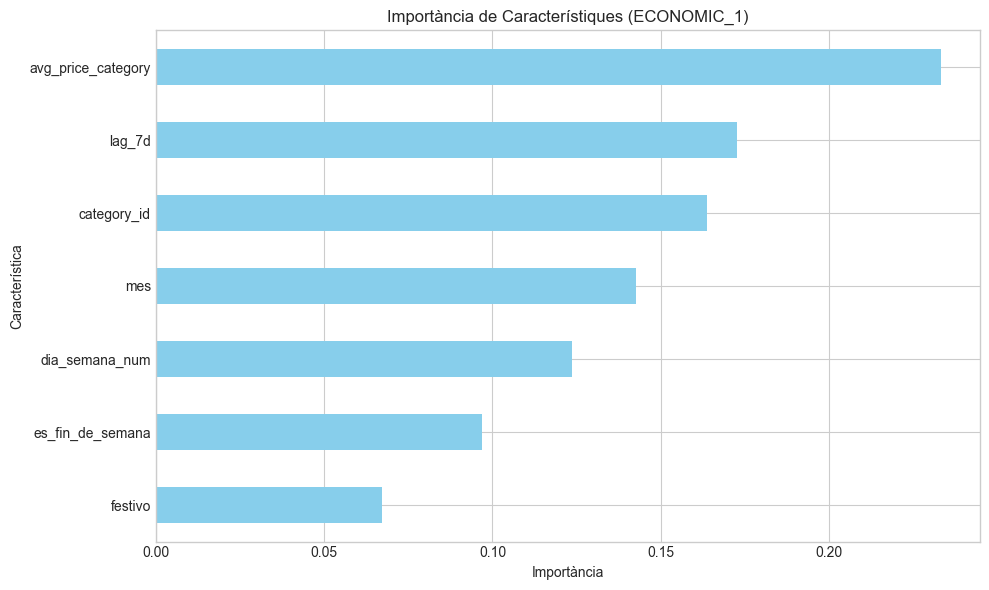

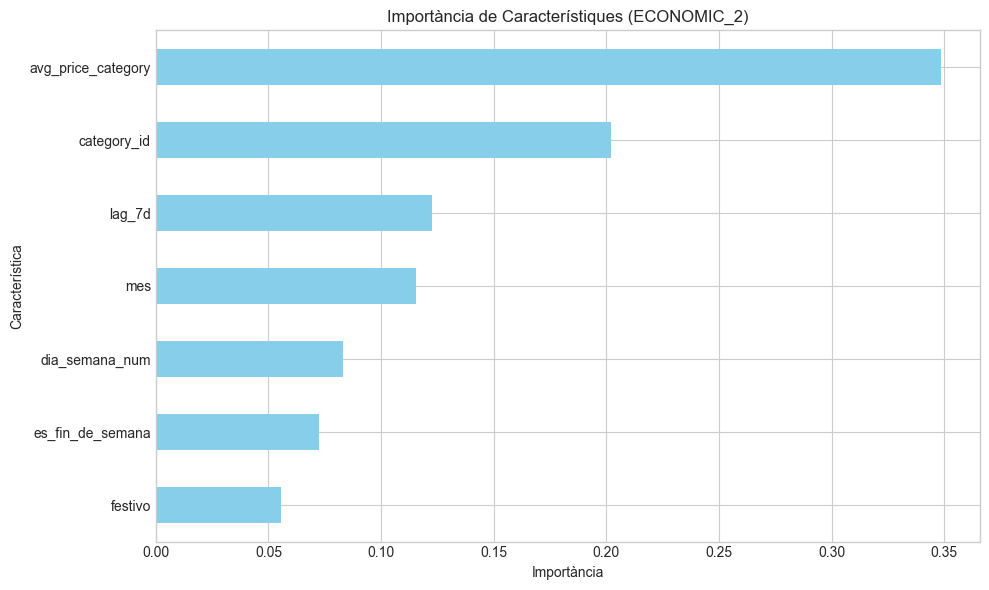

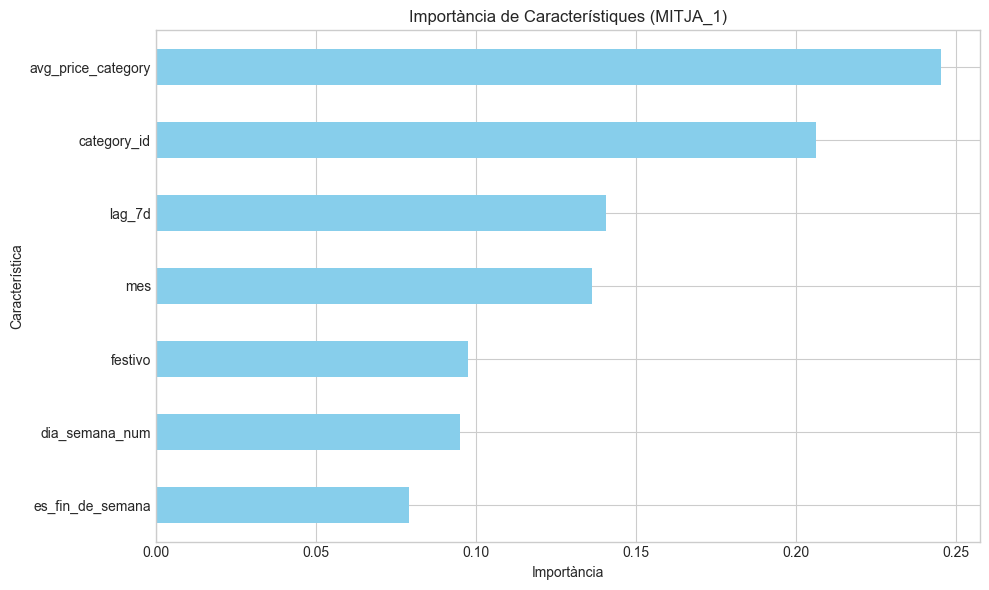

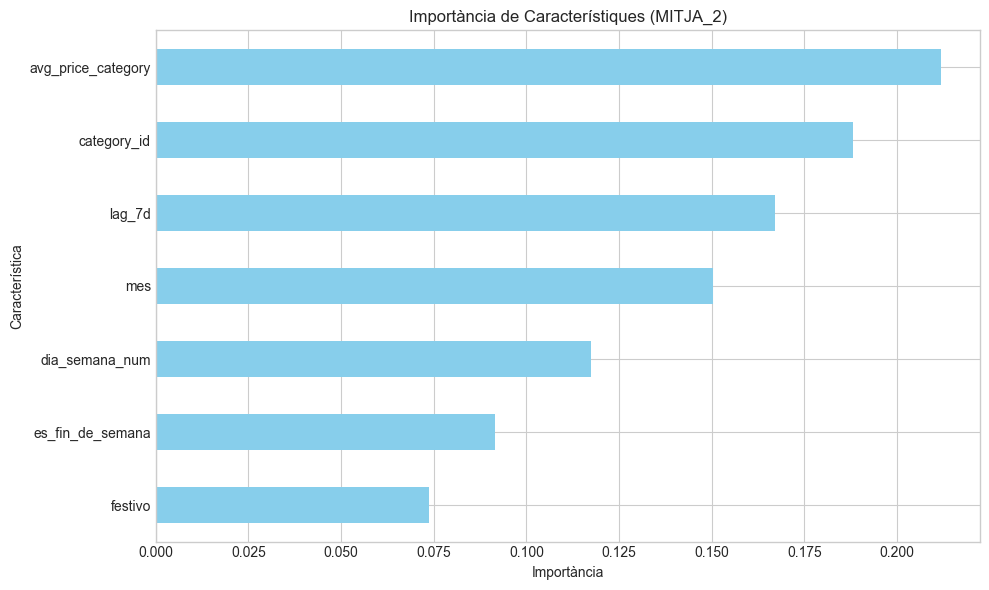

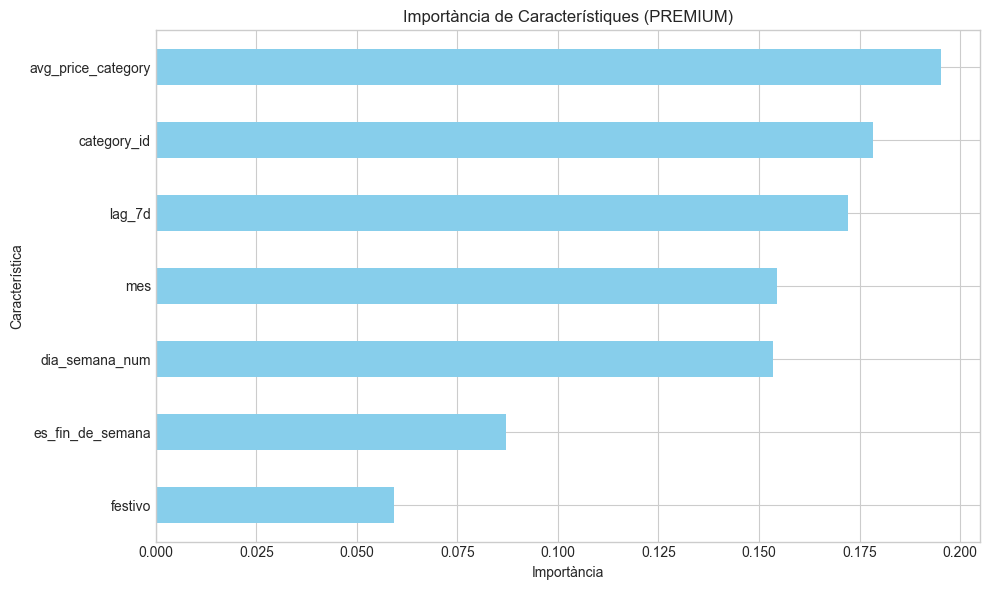

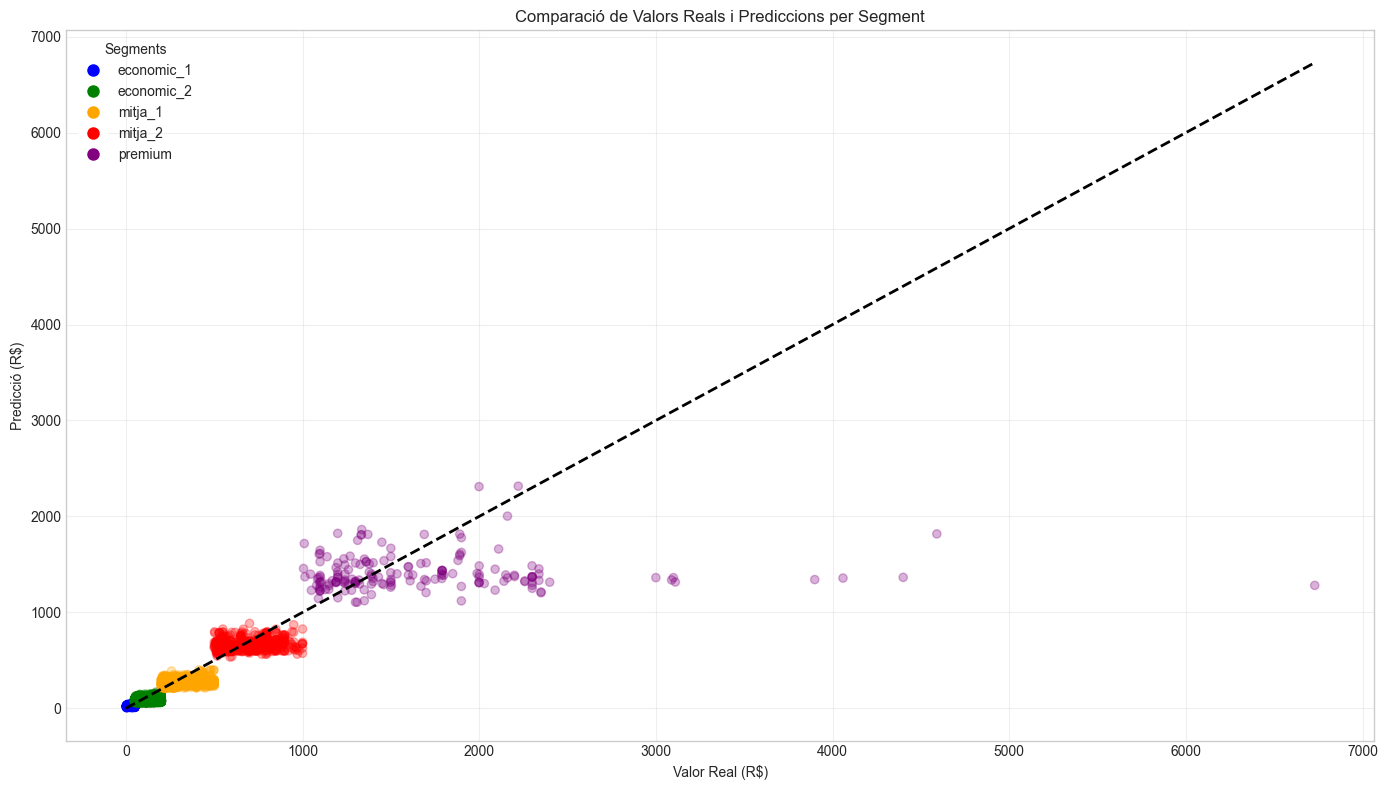

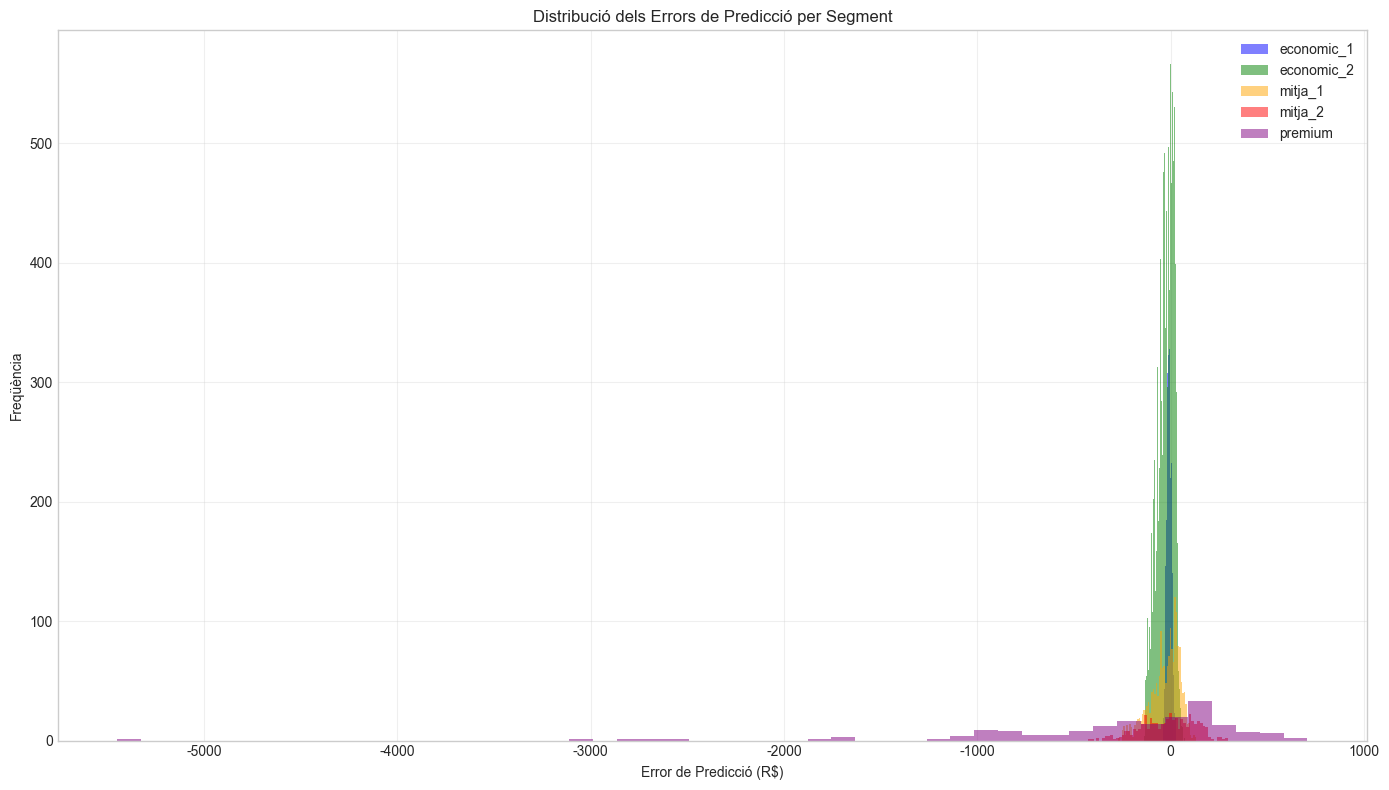

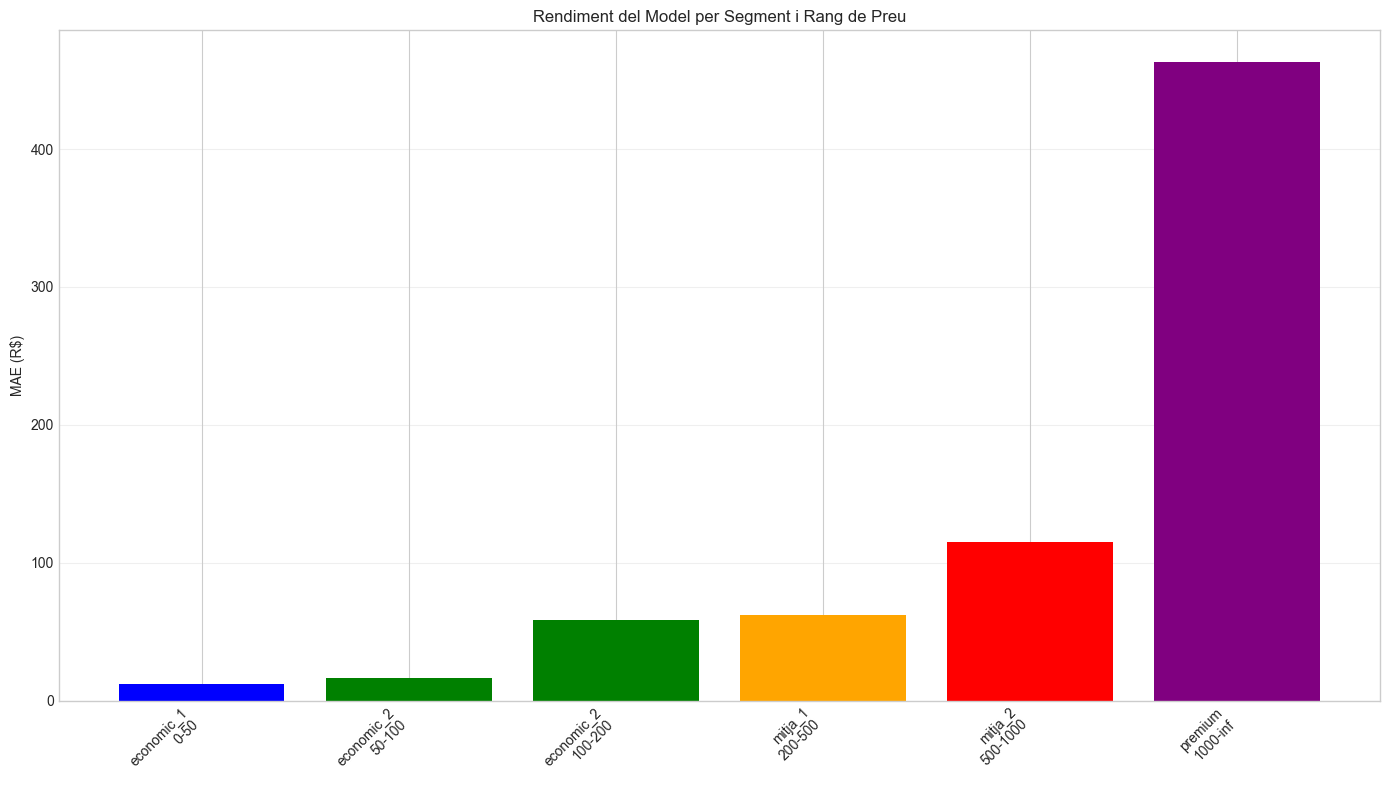


💾 DESANT RESULTATS I MODELS
✅ Model per a segment economic_1 desat com a 'model_ventas_economic_1.pkl'
✅ Model per a segment economic_2 desat com a 'model_ventas_economic_2.pkl'
✅ Model per a segment mitja_1 desat com a 'model_ventas_mitja_1.pkl'
✅ Model per a segment mitja_2 desat com a 'model_ventas_mitja_2.pkl'
✅ Model per a segment premium desat com a 'model_ventas_premium.pkl'
✅ Resultats per segment desats a 'resultats_per_segment.csv'
✅ Prediccions globals desades a 'prediccions_globals.csv'

✅ PROCÉS COMPLETAT AMB ÈXIT
📅 Hora finalització: 2025-06-21 14:21:31.019123


In [93]:
# ======================================================================
# SISTEMA DE MODELAT PREDICTIU PER SEGMENTS DE PREU - CODI DEFINITIU
# ======================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder, QuantileTransformer
from sklearn.utils import resample
import joblib
import time
import warnings

# Configuració general
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.2f}'.format)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("\n" + "="*50)
print("SISTEMA DE PREDICCIÓ DE VENDES PER SEGMENTS DE PREU")
print("="*50)

# 1. PREPARACIÓ DE DADES --------------------------------------------------
print("\n🔧 PREPARANT DADES PER A MODELAT...")

# Assegurem que no hi hagi valors nuls a les característiques clau
df_final = df_final.dropna(subset=['lag_7d', 'avg_price_category', 'price'])

# Codificar categories de producte
le = LabelEncoder()
df_final['category_id'] = le.fit_transform(df_final['categoria_catala'])

# Definir segments de preu millorats
bins = [-np.inf, 50, 200, 500, 1000, np.inf]
labels = ['economic_1', 'economic_2', 'mitja_1', 'mitja_2', 'premium']
df_final['segment_preu'] = pd.cut(
    df_final['price'],
    bins=bins,
    labels=labels,
    right=False
)

# Transformació del target per reduir l'efecte d'outliers
qt = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=42)
df_final['price_transformed'] = qt.fit_transform(df_final[['price']])

# Definir conjunt de característiques millorat
features = [
    'category_id', 
    'lag_7d', 
    'dia_semana_num',
    'es_fin_de_semana',
    'avg_price_category',
    'festivo',
    'mes'
]

# 2. PROCESSAMENT ESPECÍFIC PER SEGMENT -----------------------------------
print("\n🔍 ANALITZANT I PREPARANT CADA SEGMENT...")

# Configuració específica per a cada segment
segment_config = {
    'economic_1': {
        'depth': 8,
        'learning_rate': 0.05,
        'weight_low': 5.0,
        'n_estimators': 500
    },
    'economic_2': {
        'depth': 7,
        'learning_rate': 0.04,
        'weight_low': 4.0,
        'n_estimators': 450
    },
    'mitja_1': {
        'depth': 6,
        'learning_rate': 0.03,
        'weight_low': 3.0,
        'n_estimators': 400
    },
    'mitja_2': {
        'depth': 6,
        'learning_rate': 0.03,
        'weight_low': 2.5,
        'n_estimators': 400
    },
    'premium': {
        'depth': 5,
        'learning_rate': 0.02,
        'weight_low': 1.5,
        'n_estimators': 300
    }
}

# 3. ENTRENAMENT DE MODELS PER SEGMENT ------------------------------------
print("\n" + "="*50)
print("🚀 ENTRENANT MODELS PER CADA SEGMENT")
print("="*50)

models = {}
segment_results = {}
df_train_all = pd.DataFrame()
df_test_all = pd.DataFrame()

for segment in labels:
    print(f"\n🔹 SEGMENT: {segment.upper()}")
    
    # Filtrar dades per segment
    df_segment = df_final[df_final['segment_preu'] == segment].copy()
    
    # Divisió temporal
    df_train_seg = df_segment[df_segment['order_purchase_timestamp'] < '2018-06-01']
    df_test_seg = df_segment[df_segment['order_purchase_timestamp'] >= '2018-06-01']
    
    # Sobremostreig per a segments amb pocs registres
    min_samples = 1000
    if len(df_train_seg) < min_samples and segment == 'premium':
        df_train_seg = resample(
            df_train_seg,
            replace=True,
            n_samples=min_samples,
            random_state=42
        )
        print(f"⚠️  Sobremostreig aplicat: {len(df_train_seg)} registres d'entrenament")
    
    if len(df_train_seg) < 100 or len(df_test_seg) < 20:
        print(f"⛔ Massa pocs registres ({len(df_train_seg)} train, {len(df_test_seg)} test). Ometent...")
        continue
    
    print(f"📊 Registres entrenament: {len(df_train_seg)}")
    print(f"📊 Registres prova: {len(df_test_seg)}")
    
    # Configurar pesos per a segments
    config = segment_config.get(segment, {})
    sample_weights = np.ones(len(df_train_seg))
    
    # Assignar més pes a valors baixos dins del segment
    price_threshold = df_train_seg['price'].quantile(0.3)
    sample_weights = np.where(
        df_train_seg['price'] < price_threshold,
        config.get('weight_low', 1.0),
        1.0
    )
    
    # Configuració del model adaptada al segment
    model = XGBRegressor(
        objective='reg:squarederror',
        n_estimators=config.get('n_estimators', 400),
        learning_rate=config.get('learning_rate', 0.03),
        max_depth=config.get('depth', 6),
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.5 if segment.startswith('economic') else 0.1,
        reg_lambda=0.8 if segment.startswith('economic') else 0.3,
        random_state=42
    )
    
    # Entrenament amb pesos
    start_time = time.time()
    model.fit(
        df_train_seg[features], 
        df_train_seg['price_transformed'],
        sample_weight=sample_weights,
        verbose=0
    )
    training_time = time.time() - start_time
    print(f"⏱  Temps d'entrenament: {training_time:.2f} segons")
    
    # Predicció i transformació inversa
    preds_transformed = model.predict(df_test_seg[features])
    preds = qt.inverse_transform(preds_transformed.reshape(-1, 1)).flatten()
    
    # Càlcul de mètriques
    mae = mean_absolute_error(df_test_seg['price'], preds)
    rmse = np.sqrt(mean_squared_error(df_test_seg['price'], preds))
    mean_price = df_test_seg['price'].mean()
    mae_percent = (mae / mean_price) * 100
    
    # Resultats per rang de preu
    error_ranges = []
    for rng in [(0, 50), (50, 100), (100, 200), (200, 500), (500, 1000), (1000, np.inf)]:
        mask = (df_test_seg['price'] >= rng[0]) & (df_test_seg['price'] < rng[1])
        if mask.sum() > 0:
            mae_range = mean_absolute_error(df_test_seg.loc[mask, 'price'], preds[mask])
            error_ranges.append({
                'rang': f"{rng[0]}-{rng[1]}",
                'mae': mae_range,
                'n': mask.sum()
            })
    
    print(f"📈  Resultats:")
    print(f"- MAE: R${mae:.2f} ({mae_percent:.1f}% del preu mitjà)")
    print(f"- RMSE: R${rmse:.2f}")
    
    # Emmagatzemar model i resultats
    models[segment] = model
    segment_results[segment] = {
        'mae': mae,
        'rmse': rmse,
        'mae_percent': mae_percent,
        'n_train': len(df_train_seg),
        'n_test': len(df_test_seg),
        'error_ranges': error_ranges
    }
    
    # Guardar conjunts per a anàlisi global
    df_train_seg['prediccio_price'] = qt.inverse_transform(
        model.predict(df_train_seg[features]).reshape(-1, 1)
    ).flatten()
    df_test_seg['prediccio_price'] = preds
    df_test_seg['model_segment'] = segment
    
    df_train_all = pd.concat([df_train_all, df_train_seg])
    df_test_all = pd.concat([df_test_all, df_test_seg])

# 4. AVALUACIÓ GLOBAL I DETALLADA -----------------------------------------
print("\n" + "="*50)
print("📊 AVALUACIÓ GLOBAL DEL SISTEMA")
print("="*50)

if not df_test_all.empty:
    # Mètriques globals
    global_mae = mean_absolute_error(df_test_all['price'], df_test_all['prediccio_price'])
    global_rmse = np.sqrt(mean_squared_error(df_test_all['price'], df_test_all['prediccio_price']))
    global_mean_price = df_test_all['price'].mean()
    global_mae_percent = (global_mae / global_mean_price) * 100
    
    print(f"\n🌍 RESULTATS GLOBALS:")
    print(f"- MAE Global: R${global_mae:.2f} ({global_mae_percent:.1f}% del preu mitjà)")
    print(f"- RMSE Global: R${global_rmse:.2f}")
    
    # Comparativa per segments
    print("\n🔍 COMPARATIVA PER SEGMENTS:")
    for segment, res in segment_results.items():
        print(f"\n- {segment.upper()}:")
        print(f"  MAE: R${res['mae']:.2f} ({res['mae_percent']:.1f}%)")
        print(f"  Registres prova: {res['n_test']}")
        
        # Detall per rangs de preu
        if res['error_ranges']:
            print("  MAE per rang de preu:")
            for err in res['error_ranges']:
                print(f"    {err['rang']} R$: {err['mae']:.2f} (n={err['n']})")

# 5. VISUALITZACIÓ DE RESULTATS -------------------------------------------
print("\n" + "="*50)
print("📊 VISUALITZACIÓ DE RESULTATS")
print("="*50)

# 5.1. Importància de característiques per segment
for segment in models.keys():
    plt.figure(figsize=(10, 6))
    feature_importances = pd.Series(
        models[segment].feature_importances_, 
        index=features
    )
    feature_importances.sort_values().plot(kind='barh', color='skyblue')
    plt.title(f'Importància de Característiques ({segment.upper()})')
    plt.xlabel('Importància')
    plt.ylabel('Característica')
    plt.tight_layout()
    plt.savefig(f'feature_importance_{segment}.png')
    plt.show()

# 5.2. Prediccions vs Reals globals
plt.figure(figsize=(14, 8))
colors = {'economic_1': 'blue', 'economic_2': 'green', 'mitja_1': 'orange', 'mitja_2': 'red', 'premium': 'purple'}
segment_colors = [colors.get(s, 'gray') for s in df_test_all['model_segment']]

plt.scatter(
    df_test_all['price'], 
    df_test_all['prediccio_price'], 
    alpha=0.3, 
    c=segment_colors
)
plt.plot([0, df_test_all['price'].max()], [0, df_test_all['price'].max()], '--k', linewidth=2)
plt.xlabel('Valor Real (R$)')
plt.ylabel('Predicció (R$)')
plt.title('Comparació de Valors Reals i Prediccions per Segment')

# Llegenda personalitzada
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=seg)
                   for seg, color in colors.items()]
plt.legend(handles=legend_elements, title='Segments')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('prediccions_vs_reals_segments.png')
plt.show()

# 5.3. Histograma d'errors per segment
plt.figure(figsize=(14, 8))
for segment, color in colors.items():
    if segment in df_test_all['model_segment'].unique():
        segment_data = df_test_all[df_test_all['model_segment'] == segment]
        errors = segment_data['prediccio_price'] - segment_data['price']
        plt.hist(errors, bins=50, alpha=0.5, label=segment, color=color)

plt.xlabel('Error de Predicció (R$)')
plt.ylabel('Freqüència')
plt.title('Distribució dels Errors de Predicció per Segment')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('distribucio_errors_per_segment.png')
plt.show()

# 5.4. Rendiment per rang de preu
if segment_results:
    fig, ax = plt.subplots(figsize=(14, 8))
    rangs = []
    mae_values = []
    bar_colors = []  # Nom canviat per evitar conflicte
    
    # Utilitzem el diccionari de colors definit anteriorment
    segment_color_map = {'economic_1': 'blue', 'economic_2': 'green', 
                        'mitja_1': 'orange', 'mitja_2': 'red', 'premium': 'purple'}
    
    for segment, res in segment_results.items():
        for err in res['error_ranges']:
            rangs.append(f"{segment}\n{err['rang']}")
            mae_values.append(err['mae'])
            # Obtenim el color del segment del diccionari
            bar_colors.append(segment_color_map.get(segment, 'gray'))  # CORRECCIÓ CLAU
    
    ax.bar(rangs, mae_values, color=bar_colors)
    ax.set_ylabel('MAE (R$)')
    ax.set_title('Rendiment del Model per Segment i Rang de Preu')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('rendiment_per_rang_preu.png')
    plt.show()

# 6. DESAR MODEL I RESULTATS -----------------------------------------------
print("\n" + "="*50)
print("💾 DESANT RESULTATS I MODELS")
print("="*50)

# 6.1. Desar models
for segment, model in models.items():
    joblib.dump(model, f'model_ventas_{segment}.pkl')
    print(f"✅ Model per a segment {segment} desat com a 'model_ventas_{segment}.pkl'")

# 6.2. Desar resultats per segment
df_results_segment = pd.DataFrame(segment_results).T
df_results_segment.to_csv('resultats_per_segment.csv')
print("✅ Resultats per segment desats a 'resultats_per_segment.csv'")

# 6.3. Desar prediccions globals
if not df_test_all.empty:
    # Calcular l'error com a part del procés
    df_test_all['error'] = df_test_all['prediccio_price'] - df_test_all['price']
    
    # Seleccionar només les columnes existents
    columns_to_export = [
        'order_id', 'product_id', 'categoria_catala', 'price', 
        'prediccio_price', 'segment_preu', 'model_segment', 'error'
    ]
    
    # Filtrar columnes que realment existeixen
    existing_columns = [col for col in columns_to_export if col in df_test_all.columns]
    
    df_test_all[existing_columns].to_csv('prediccions_globals.csv', index=False)
    print("✅ Prediccions globals desades a 'prediccions_globals.csv'")

# 6.4. Desar informe de rendiment
with open('informe_rendiment.txt', 'w') as f:
    f.write("INFORME DE RENDIMENT DEL MODEL PREDICTIU\n")
    f.write("="*50 + "\n\n")
    f.write(f"MAE Global: R${global_mae:.2f} ({global_mae_percent:.1f}% del preu mitjà)\n")
    f.write(f"RMSE Global: R${global_rmse:.2f}\n\n")
    
    f.write("RESULTATS PER SEGMENT:\n")
    for segment, res in segment_results.items():
        f.write(f"\n- {segment.upper()}:\n")
        f.write(f"  MAE: R${res['mae']:.2f} ({res['mae_percent']:.1f}%)\n")
        f.write(f"  Registres prova: {res['n_test']}\n")
        
        if res['error_ranges']:
            f.write("  MAE per rang de preu:\n")
            for err in res['error_ranges']:
                f.write(f"    {err['rang']} R$: {err['mae']:.2f} (n={err['n']})\n")

print("\n" + "="*50)
print("✅ PROCÉS COMPLETAT AMB ÈXIT")
print(f"📅 Hora finalització: {pd.Timestamp.now()}")
print("="*50)


SISTEMA DE PREDICCIÓ DE VENDES PER CATEGORIA

🔧 PREPARANT DADES PER A MODELAT...
⚙️ Categories amb suficients dades (500+ registres): 29
⚙️ Categories petites (agrupades com 'altres'): 41

🚀 ENTRENANT MODELS PER CATEGORIA


Entrenant models:   3%|▎         | 1/30 [00:00<00:03,  9.39it/s]


🔹 CATEGORIA: LLIT_BANY_TAULA
📊 Registres entrenament: 9060
📊 Registres prova: 2055
⏱  Temps d'entrenament: 0.06 segons
🏆 Millor iteració: 0 (MAE validació: 51.74)
📈  Resultats per a llit_bany_taula:
- MAE: R$51.74 (56.6% del preu mitjà)
- RMSE: R$100.87
💾 Model desat com a 'models_per_categoria/model_llit_bany_taula.pkl'

🔹 CATEGORIA: SALUT_BELLESA
📊 Registres entrenament: 7152
📊 Registres prova: 2518


Entrenant models:   7%|▋         | 2/30 [00:00<00:07,  3.92it/s]

⏱  Temps d'entrenament: 0.30 segons
🏆 Millor iteració: 165 (MAE validació: 95.59)
📈  Resultats per a salut_bellesa:
- MAE: R$95.59 (71.9% del preu mitjà)
- RMSE: R$178.37
💾 Model desat com a 'models_per_categoria/model_salut_bellesa.pkl'

🔹 CATEGORIA: ESPORTS_OCI
📊 Registres entrenament: 7272
📊 Registres prova: 1369


Entrenant models:  13%|█▎        | 4/30 [00:00<00:05,  4.99it/s]

⏱  Temps d'entrenament: 0.20 segons
🏆 Millor iteració: 149 (MAE validació: 77.64)
📈  Resultats per a esports_oci:
- MAE: R$77.64 (69.6% del preu mitjà)
- RMSE: R$193.77
💾 Model desat com a 'models_per_categoria/model_esports_oci.pkl'

🔹 CATEGORIA: MOBLES_DECORACIÓ
📊 Registres entrenament: 7056
📊 Registres prova: 1278
⏱  Temps d'entrenament: 0.06 segons
🏆 Millor iteració: 15 (MAE validació: 59.76)
📈  Resultats per a mobles_decoració:
- MAE: R$59.76 (59.1% del preu mitjà)
- RMSE: R$110.73
💾 Model desat com a 'models_per_categoria/model_mobles_decoració.pkl'

🔹 CATEGORIA: ACCESSORIS_INFORMÀTICS
📊 Registres entrenament: 6573
📊 Registres prova: 1254


Entrenant models:  20%|██        | 6/30 [00:01<00:03,  6.04it/s]

⏱  Temps d'entrenament: 0.13 segons
🏆 Millor iteració: 80 (MAE validació: 67.46)
📈  Resultats per a accessoris_informàtics:
- MAE: R$67.46 (67.9% del preu mitjà)
- RMSE: R$103.28
💾 Model desat com a 'models_per_categoria/model_accessoris_informàtics.pkl'

🔹 CATEGORIA: ARTICLES_LLAR
📊 Registres entrenament: 5174
📊 Registres prova: 1790
⏱  Temps d'entrenament: 0.06 segons
🏆 Millor iteració: 12 (MAE validació: 71.49)
📈  Resultats per a articles_llar:
- MAE: R$71.49 (70.9% del preu mitjà)
- RMSE: R$154.62
💾 Model desat com a 'models_per_categoria/model_articles_llar.pkl'

🔹 CATEGORIA: RELLOTGES_REGALS
📊 Registres entrenament: 4566
📊 Registres prova: 1425


Entrenant models:  23%|██▎       | 7/30 [00:01<00:03,  5.85it/s]

⏱  Temps d'entrenament: 0.10 segons
🏆 Millor iteració: 58 (MAE validació: 138.21)
📈  Resultats per a rellotges_regals:
- MAE: R$138.21 (77.1% del preu mitjà)
- RMSE: R$228.49
💾 Model desat com a 'models_per_categoria/model_rellotges_regals.pkl'

🔹 CATEGORIA: TELEFONIA
📊 Registres entrenament: 3824
📊 Registres prova: 721


Entrenant models:  30%|███       | 9/30 [00:01<00:03,  6.62it/s]

⏱  Temps d'entrenament: 0.13 segons
🏆 Millor iteració: 12 (MAE validació: 103.80)
📈  Resultats per a telefonia:
- MAE: R$103.80 (85.8% del preu mitjà)
- RMSE: R$223.72
💾 Model desat com a 'models_per_categoria/model_telefonia.pkl'

🔹 CATEGORIA: EINES_JARDÍ
📊 Registres entrenament: 3845
📊 Registres prova: 502
⏱  Temps d'entrenament: 0.06 segons
🏆 Millor iteració: 0 (MAE validació: 90.63)
📈  Resultats per a eines_jardí:
- MAE: R$90.63 (75.0% del preu mitjà)
- RMSE: R$199.83
💾 Model desat com a 'models_per_categoria/model_eines_jardí.pkl'

🔹 CATEGORIA: AUTOMÒBIL
📊 Registres entrenament: 3214
📊 Registres prova: 1021
⏱  Temps d'entrenament: 0.05 segons
🏆 Millor iteració: 6 (MAE validació: 122.16)
📈  Resultats per a automòbil:
- MAE: R$122.16 (92.7% del preu mitjà)
- RMSE: R$253.83
💾 Model desat com a 'models_per_categoria/model_automòbil.pkl'

🔹 CATEGORIA: JOGUINES
📊 Registres entrenament: 3600
📊 Registres prova: 517
⏱  Temps d'entrenament: 0.17 segons
🏆 Millor iteració: 143 (MAE validació:

Entrenant models:  40%|████      | 12/30 [00:02<00:02,  6.74it/s]

💾 Model desat com a 'models_per_categoria/model_joguines.pkl'

🔹 CATEGORIA: PRODUCTES_INTERESSANTS
📊 Registres entrenament: 3449
📊 Registres prova: 347
⏱  Temps d'entrenament: 0.10 segons
🏆 Millor iteració: 70 (MAE validació: 126.09)
📈  Resultats per a productes_interessants:
- MAE: R$126.09 (66.1% del preu mitjà)
- RMSE: R$320.31
💾 Model desat com a 'models_per_categoria/model_productes_interessants.pkl'

🔹 CATEGORIA: PERFUMERIA
📊 Registres entrenament: 2802
📊 Registres prova: 617


Entrenant models:  47%|████▋     | 14/30 [00:02<00:02,  7.41it/s]

⏱  Temps d'entrenament: 0.05 segons
🏆 Millor iteració: 15 (MAE validació: 70.18)
📈  Resultats per a perfumeria:
- MAE: R$70.18 (57.9% del preu mitjà)
- RMSE: R$103.54
💾 Model desat com a 'models_per_categoria/model_perfumeria.pkl'

🔹 CATEGORIA: NADONS
📊 Registres entrenament: 2401
📊 Registres prova: 664
⏱  Temps d'entrenament: 0.09 segons
🏆 Millor iteració: 46 (MAE validació: 89.91)
📈  Resultats per a nadons:
- MAE: R$89.91 (79.7% del preu mitjà)
- RMSE: R$201.57
💾 Model desat com a 'models_per_categoria/model_nadons.pkl'

🔹 CATEGORIA: ELECTRÒNICA
📊 Registres entrenament: 2297
📊 Registres prova: 470
⏱  Temps d'entrenament: 0.04 segons
🏆 Millor iteració: 1 (MAE validació: 57.09)
📈  Resultats per a electrònica:
- MAE: R$57.09 (85.0% del preu mitjà)
- RMSE: R$112.19
💾 Model desat com a 'models_per_categoria/model_electrònica.pkl'

🔹 CATEGORIA: PAPERERIA
📊 Registres entrenament: 1989
📊 Registres prova: 528


Entrenant models:  53%|█████▎    | 16/30 [00:02<00:01,  7.01it/s]

⏱  Temps d'entrenament: 0.18 segons
🏆 Millor iteració: 103 (MAE validació: 53.17)
📈  Resultats per a papereria:
- MAE: R$53.17 (61.5% del preu mitjà)
- RMSE: R$91.28
💾 Model desat com a 'models_per_categoria/model_papereria.pkl'

🔹 CATEGORIA: MODA_BOLSOS_ACCESSORIS
📊 Registres entrenament: 1740
📊 Registres prova: 291
⏱  Temps d'entrenament: 0.14 segons
🏆 Millor iteració: 130 (MAE validació: 41.24)
📈  Resultats per a moda_bolsos_accessoris:
- MAE: R$41.24 (54.0% del preu mitjà)
- RMSE: R$79.25
💾 Model desat com a 'models_per_categoria/model_moda_bolsos_accessoris.pkl'


Entrenant models:  60%|██████    | 18/30 [00:02<00:01,  6.64it/s]


🔹 CATEGORIA: BOTIGA_MASCOTES
📊 Registres entrenament: 1410
📊 Registres prova: 537
⏱  Temps d'entrenament: 0.08 segons
🏆 Millor iteració: 34 (MAE validació: 70.09)
📈  Resultats per a botiga_mascotes:
- MAE: R$70.09 (58.9% del preu mitjà)
- RMSE: R$156.06
💾 Model desat com a 'models_per_categoria/model_botiga_mascotes.pkl'

🔹 CATEGORIA: MOBLES_OFICINA
📊 Registres entrenament: 1502
📊 Registres prova: 189


Entrenant models:  67%|██████▋   | 20/30 [00:03<00:01,  7.67it/s]

⏱  Temps d'entrenament: 0.07 segons
🏆 Millor iteració: 45 (MAE validació: 66.98)
📈  Resultats per a mobles_oficina:
- MAE: R$66.98 (38.1% del preu mitjà)
- RMSE: R$106.00
💾 Model desat com a 'models_per_categoria/model_mobles_oficina.pkl'

🔹 CATEGORIA: CONSOLES_JOCS
📊 Registres entrenament: 983
📊 Registres prova: 154
⏱  Temps d'entrenament: 0.07 segons
🏆 Millor iteració: 28 (MAE validació: 115.31)
📈  Resultats per a consoles_jocs:
- MAE: R$115.31 (87.7% del preu mitjà)
- RMSE: R$215.32
💾 Model desat com a 'models_per_categoria/model_consoles_jocs.pkl'

🔹 CATEGORIA: EQUIPATGE_ACCESSORIS
📊 Registres entrenament: 936
📊 Registres prova: 156


Entrenant models:  73%|███████▎  | 22/30 [00:03<00:01,  7.66it/s]

⏱  Temps d'entrenament: 0.09 segons
🏆 Millor iteració: 48 (MAE validació: 55.72)
📈  Resultats per a equipatge_accessoris:
- MAE: R$55.72 (49.0% del preu mitjà)
- RMSE: R$84.66
💾 Model desat com a 'models_per_categoria/model_equipatge_accessoris.pkl'

🔹 CATEGORIA: EINES_CONSTRUCCIÓ
📊 Registres entrenament: 612
📊 Registres prova: 420
⏱  Temps d'entrenament: 0.10 segons
🏆 Millor iteració: 0 (MAE validació: 136.55)
📈  Resultats per a eines_construcció:
- MAE: R$136.55 (83.9% del preu mitjà)
- RMSE: R$304.34
💾 Model desat com a 'models_per_categoria/model_eines_construcció.pkl'

🔹 CATEGORIA: ELECTRODOMÈSTICS_LLAR
📊 Registres entrenament: 560
📊 Registres prova: 211


Entrenant models:  80%|████████  | 24/30 [00:03<00:00,  9.38it/s]

⏱  Temps d'entrenament: 0.05 segons
🏆 Millor iteració: 15 (MAE validació: 71.65)
📈  Resultats per a electrodomèstics_llar:
- MAE: R$71.65 (85.0% del preu mitjà)
- RMSE: R$161.02
💾 Model desat com a 'models_per_categoria/model_electrodomèstics_llar.pkl'

🔹 CATEGORIA: INSTRUMENTS_MUSICALS
📊 Registres entrenament: 555
📊 Registres prova: 125
⏱  Temps d'entrenament: 0.04 segons
🏆 Millor iteració: 0 (MAE validació: 302.82)
📈  Resultats per a instruments_musicals:
- MAE: R$302.82 (104.5% del preu mitjà)
- RMSE: R$527.12
💾 Model desat com a 'models_per_categoria/model_instruments_musicals.pkl'

🔹 CATEGORIA: ELECTRODOMÈSTICS_PETITS
📊 Registres entrenament: 561
📊 Registres prova: 118
⏱  Temps d'entrenament: 0.06 segons
🏆 Millor iteració: 23 (MAE validació: 271.37)
📈  Resultats per a electrodomèstics_petits:
- MAE: R$271.37 (101.7% del preu mitjà)
- RMSE: R$368.41
💾 Model desat com a 'models_per_categoria/model_electrodomèstics_petits.pkl'

🔹 CATEGORIA: CONSTRUCCIÓ_LLAR
📊 Registres entrenament: 4

Entrenant models:  93%|█████████▎| 28/30 [00:03<00:00, 11.50it/s]

⏱  Temps d'entrenament: 0.04 segons
🏆 Millor iteració: 1 (MAE validació: 63.38)
📈  Resultats per a construcció_llar:
- MAE: R$63.38 (50.1% del preu mitjà)
- RMSE: R$95.39
💾 Model desat com a 'models_per_categoria/model_construcció_llar.pkl'

🔹 CATEGORIA: LLIBRES_INTERÈS_GENERAL
📊 Registres entrenament: 453
📊 Registres prova: 100
⏱  Temps d'entrenament: 0.04 segons
🏆 Millor iteració: 0 (MAE validació: 79.38)
📈  Resultats per a llibres_interès_general:
- MAE: R$79.38 (88.3% del preu mitjà)
- RMSE: R$131.88
💾 Model desat com a 'models_per_categoria/model_llibres_interès_general.pkl'

🔹 CATEGORIA: ALIMENTS
📊 Registres entrenament: 306
📊 Registres prova: 204
⏱  Temps d'entrenament: 0.03 segons
🏆 Millor iteració: 8 (MAE validació: 30.81)
📈  Resultats per a aliments:
- MAE: R$30.81 (48.3% del preu mitjà)
- RMSE: R$39.23
💾 Model desat com a 'models_per_categoria/model_aliments.pkl'

🔹 CATEGORIA: MOBLES_SALA_ESTAR
📊 Registres entrenament: 379
📊 Registres prova: 124
⏱  Temps d'entrenament: 0.03 

Entrenant models: 100%|██████████| 30/30 [00:04<00:00,  7.26it/s]

💾 Model desat com a 'models_per_categoria/model_altres.pkl'

📊 AVALUACIÓ GLOBAL DEL SISTEMA

🌍 RESULTATS GLOBALS:
- MAE Global: R$87.74 (71.8% del preu mitjà)
- RMSE Global: R$190.02

🔍 COMPARATIVA PER CATEGORIES:

- LLIT_BANY_TAULA:
  MAE: R$51.74 (56.6%)
  Preu mitjà: R$91.33
  Registres entrenament: 9060
  Registres prova: 2055

- SALUT_BELLESA:
  MAE: R$95.59 (71.9%)
  Preu mitjà: R$132.85
  Registres entrenament: 7152
  Registres prova: 2518

- ESPORTS_OCI:
  MAE: R$77.64 (69.6%)
  Preu mitjà: R$111.50
  Registres entrenament: 7272
  Registres prova: 1369

- MOBLES_DECORACIÓ:
  MAE: R$59.76 (59.1%)
  Preu mitjà: R$101.16
  Registres entrenament: 7056
  Registres prova: 1278

- ACCESSORIS_INFORMÀTICS:
  MAE: R$67.46 (67.9%)
  Preu mitjà: R$99.30
  Registres entrenament: 6573
  Registres prova: 1254

- ARTICLES_LLAR:
  MAE: R$71.49 (70.9%)
  Preu mitjà: R$100.80
  Registres entrenament: 5174
  Registres prova: 1790

- RELLOTGES_REGALS:
  MAE: R$138.21 (77.1%)
  Preu mitjà: R$179.21


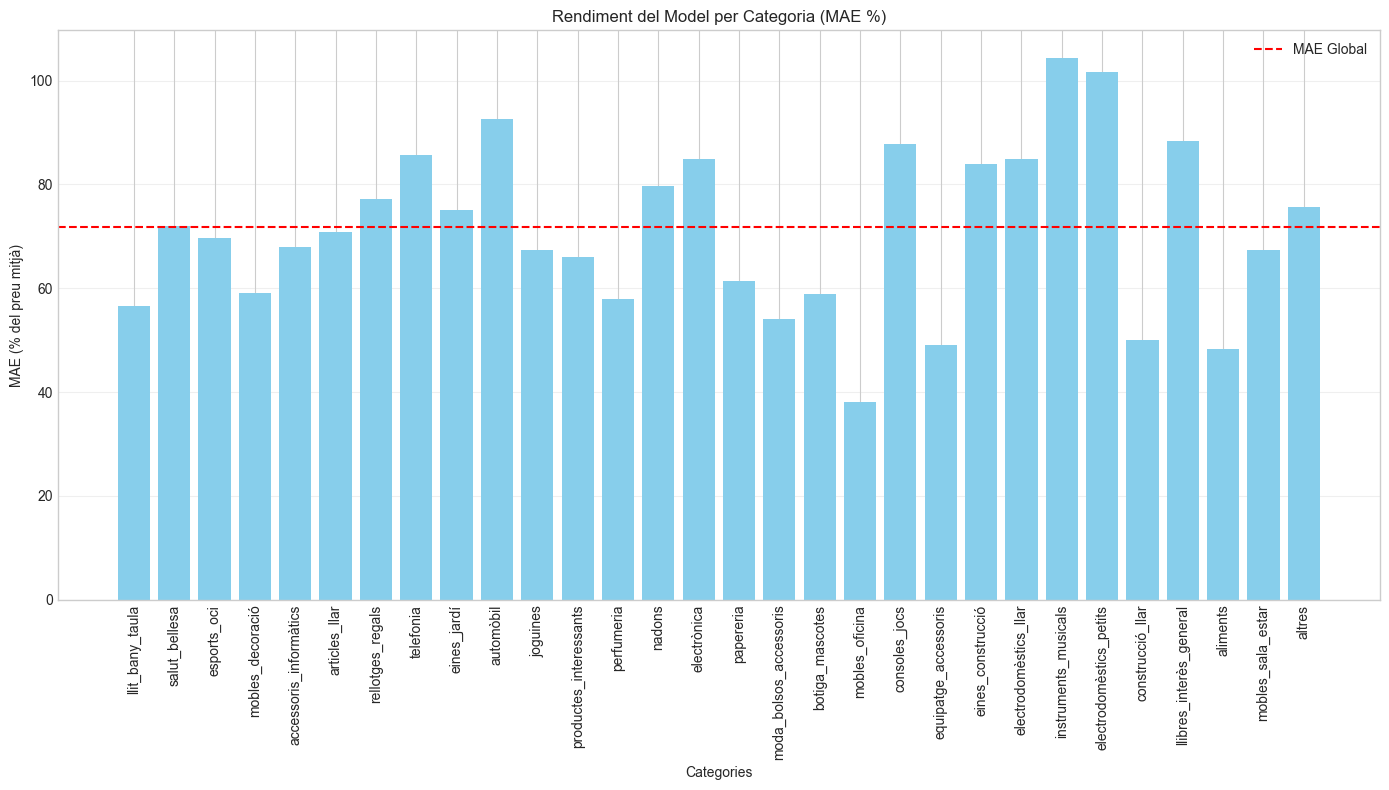

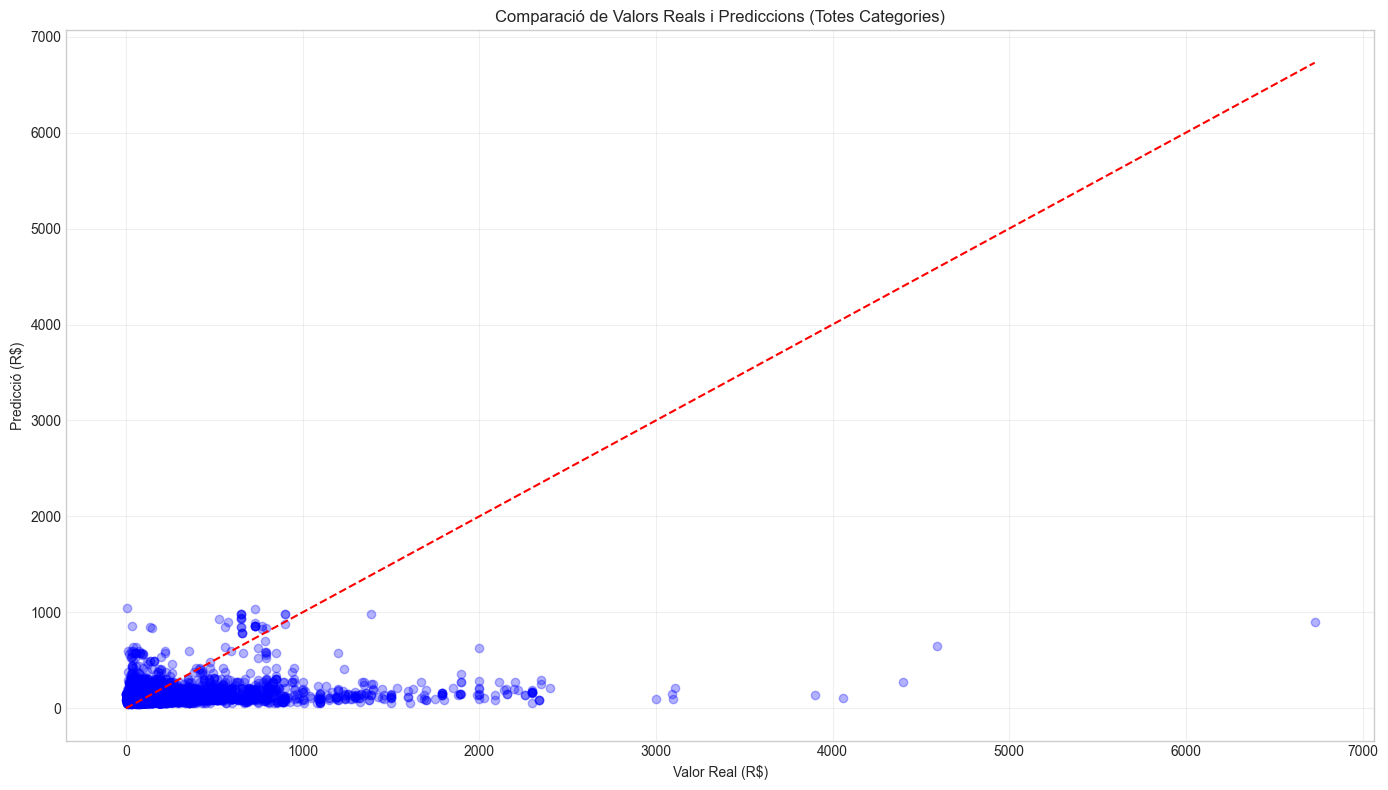

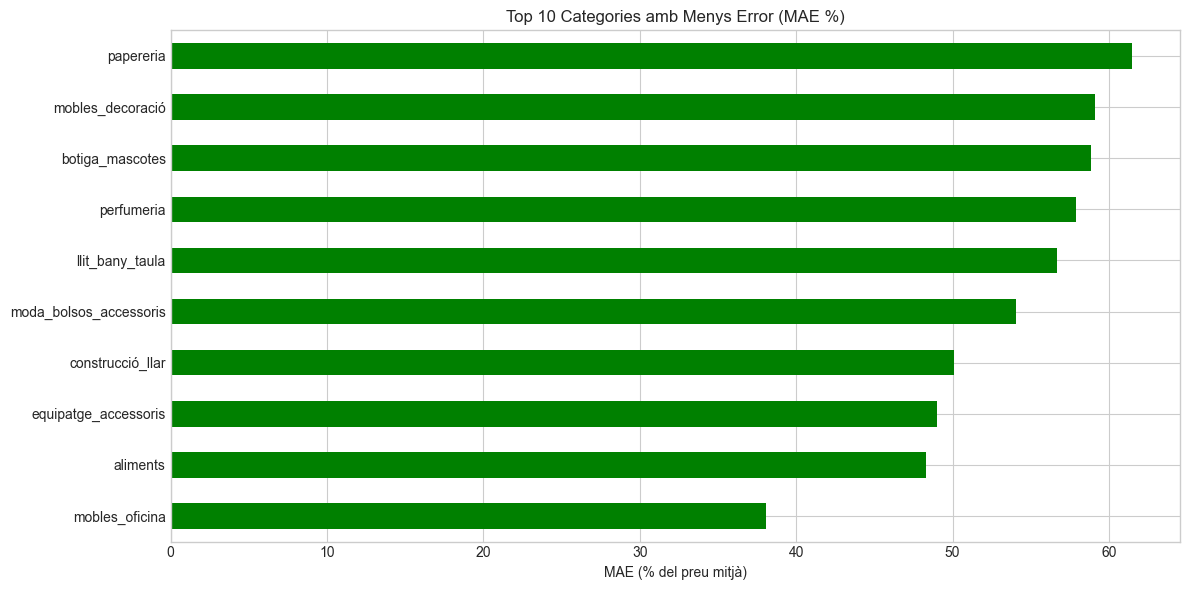

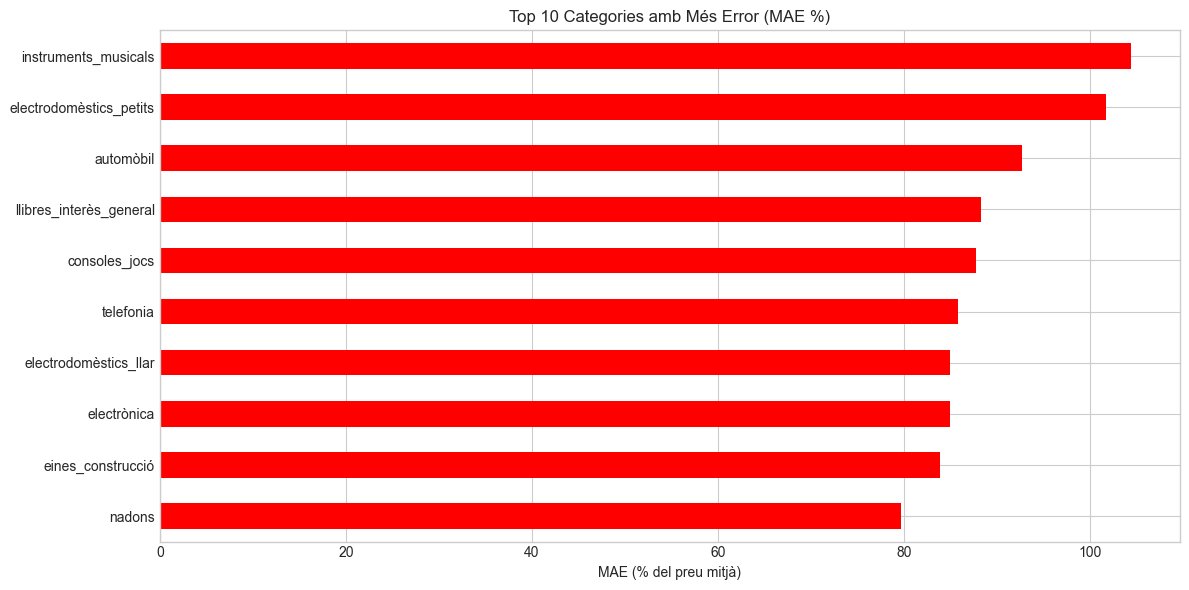


💾 DESANT RESULTATS COMPLETS
✅ Resultats per categoria desats a 'resultats_per_categoria.csv'

✅ PROCÉS COMPLETAT AMB ÈXIT
📅 Hora finalització: 2025-06-21 14:46:29.486796
📊 Total categories modelades: 30


In [96]:
# ======================================================================
# SISTEMA DE MODELAT PREDICTIU PER CATEGORIA - CODI DEFINITIU
# ======================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
import joblib
import time
import warnings
from tqdm import tqdm  # Per a barres de progrés
import os

# Configuració general
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.2f}'.format)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("\n" + "="*50)
print("SISTEMA DE PREDICCIÓ DE VENDES PER CATEGORIA")
print("="*50)

# 1. PREPARACIÓ DE DADES --------------------------------------------------
print("\n🔧 PREPARANT DADES PER A MODELAT...")

# Assegurem que no hi hagi valors nuls a les característiques clau
df_final = df_final.dropna(subset=['lag_7d', 'avg_price_category', 'price', 'categoria_catala'])

# Definir conjunt de característiques
features = [
    'lag_7d', 
    'dia_semana_num',
    'es_fin_de_semana',
    'avg_price_category',
    'festivo',
    'mes'
]

# Agrupar categories petites
category_counts = df_final['categoria_catala'].value_counts()
min_samples = 500  # Mínim de registres per categoria
categories_grans = category_counts[category_counts >= min_samples].index.tolist()
categories_petites = category_counts[category_counts < min_samples].index.tolist()

print(f"⚙️ Categories amb suficients dades ({min_samples}+ registres): {len(categories_grans)}")
print(f"⚙️ Categories petites (agrupades com 'altres'): {len(categories_petites)}")

# Crear categoria agrupada per a categories petites
df_final['categoria_agrupada'] = df_final['categoria_catala'].apply(
    lambda x: x if x in categories_grans else 'altres'
)

# Llista de categories per a modelar (incloent 'altres')
categories_per_modelar = categories_grans + ['altres'] if categories_petites else categories_grans

# 2. ENTRENAMENT DE MODELS PER CATEGORIA ----------------------------------
print("\n" + "="*50)
print("🚀 ENTRENANT MODELS PER CATEGORIA")
print("="*50)

models = {}
results = {}
global_preds = []
global_reals = []

# Crear directori per a models
os.makedirs('models_per_categoria', exist_ok=True)

for categoria in tqdm(categories_per_modelar, desc="Entrenant models"):
    print(f"\n🔹 CATEGORIA: {categoria.upper()}")
    
    # Filtrar dades per categoria
    df_cat = df_final[df_final['categoria_agrupada'] == categoria].copy()
    
    # Divisió temporal
    df_train = df_cat[df_cat['order_purchase_timestamp'] < '2018-06-01']
    df_test = df_cat[df_cat['order_purchase_timestamp'] >= '2018-06-01']
    
    # Verificar si hi ha suficients dades
    if len(df_train) < 100 or len(df_test) < 20:
        print(f"⚠️ Massa pocs registres ({len(df_train)} train, {len(df_test)} test). Ometent...")
        continue
    
    print(f"📊 Registres entrenament: {len(df_train)}")
    print(f"📊 Registres prova: {len(df_test)}")
    
    # Configuració del model adaptada a la mida de les dades
    n_estimators = min(2000, max(300, len(df_train) // 5))  # Més arbres i millor ajust
    learning_rate = 0.02 if len(df_train) > 1000 else 0.05  # Taxa d'aprenentatge més baixa

    # CORRECCIÓ: Aquest bloc HA D'ESTAR DINS DEL BUCLE PER A CADA CATEGORIA
    model = XGBRegressor(
        objective='reg:squarederror',
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        # Afegim early stopping per evitar sobreajustament
        early_stopping_rounds=30,
        eval_metric='mae'
    )
    
    # Entrenament amb monitorització de progress
    start_time = time.time()
    model.fit(
        df_train[features], 
        df_train['price'],
        # Ús del conjunt de test com a validació per a early stopping
        eval_set=[(df_test[features], df_test['price'])],
        verbose=0  # Reduïm sortida (posa 50 per veure progrés)
    )
    training_time = time.time() - start_time
    print(f"⏱  Temps d'entrenament: {training_time:.2f} segons")

    # Obtenim la millor iteració
    if hasattr(model, 'best_iteration'):
        best_iter = model.best_iteration
        print(f"🏆 Millor iteració: {best_iter} (MAE validació: {model.best_score:.2f})")
    else:
        print("ℹ️ No s'ha activat early stopping, s'han utilitzat totes les iteracions")
    
    # Predicció
    preds = model.predict(df_test[features])
    
    # Emmagatzemar per a avaluació global
    global_preds.extend(preds)
    global_reals.extend(df_test['price'].values)
    
    # Càlcul de mètriques
    mae = mean_absolute_error(df_test['price'], preds)
    rmse = np.sqrt(mean_squared_error(df_test['price'], preds))
    mean_price = df_test['price'].mean()
    mae_percent = (mae / mean_price) * 100
    
    print(f"📈  Resultats per a {categoria}:")
    print(f"- MAE: R${mae:.2f} ({mae_percent:.1f}% del preu mitjà)")
    print(f"- RMSE: R${rmse:.2f}")
    
    # Emmagatzemar model i resultats
    models[categoria] = model
    results[categoria] = {
        'mae': mae,
        'rmse': rmse,
        'mae_percent': mae_percent,
        'n_train': len(df_train),
        'n_test': len(df_test),
        'mean_price': mean_price,
        'training_time': training_time,
        'best_iterations': best_iter if 'best_iter' in locals() else n_estimators
    }
    
    # Desar model
    safe_cat_name = "".join(x for x in categoria if x.isalnum() or x in " _-")
    joblib.dump(model, f'models_per_categoria/model_{safe_cat_name}.pkl')
    print(f"💾 Model desat com a 'models_per_categoria/model_{safe_cat_name}.pkl'")
    
# 3. AVALUACIÓ GLOBAL I DETALLADA -----------------------------------------
print("\n" + "="*50)
print("📊 AVALUACIÓ GLOBAL DEL SISTEMA")
print("="*50)

if global_preds:
    # Mètriques globals
    global_mae = mean_absolute_error(global_reals, global_preds)
    global_rmse = np.sqrt(mean_squared_error(global_reals, global_preds))
    global_mean_price = np.mean(global_reals)
    global_mae_percent = (global_mae / global_mean_price) * 100
    
    print(f"\n🌍 RESULTATS GLOBALS:")
    print(f"- MAE Global: R${global_mae:.2f} ({global_mae_percent:.1f}% del preu mitjà)")
    print(f"- RMSE Global: R${global_rmse:.2f}")
    
    # Comparativa per categories
    print("\n🔍 COMPARATIVA PER CATEGORIES:")
    for categoria, res in results.items():
        print(f"\n- {categoria.upper()}:")
        print(f"  MAE: R${res['mae']:.2f} ({res['mae_percent']:.1f}%)")
        print(f"  Preu mitjà: R${res['mean_price']:.2f}")
        print(f"  Registres entrenament: {res['n_train']}")
        print(f"  Registres prova: {res['n_test']}")

# 4. VISUALITZACIÓ DE RESULTATS -------------------------------------------
print("\n" + "="*50)
print("📊 VISUALITZACIÓ DE RESULTATS")
print("="*50)

# 4.1. MAE per categoria
if results:
    categorias = list(results.keys())
    mae_values = [res['mae_percent'] for res in results.values()]
    
    plt.figure(figsize=(14, 8))
    plt.bar(categorias, mae_values, color='skyblue')
    plt.axhline(y=global_mae_percent, color='r', linestyle='--', label='MAE Global')
    plt.xlabel('Categories')
    plt.ylabel('MAE (% del preu mitjà)')
    plt.title('Rendiment del Model per Categoria (MAE %)')
    plt.xticks(rotation=90)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('mae_per_categoria.png')
    plt.show()

# 4.2. Prediccions vs Reals globals
if global_preds:
    plt.figure(figsize=(14, 8))
    plt.scatter(global_reals, global_preds, alpha=0.3, color='blue')
    max_val = max(max(global_reals), max(global_preds))
    plt.plot([0, max_val], [0, max_val], '--r')
    plt.xlabel('Valor Real (R$)')
    plt.ylabel('Predicció (R$)')
    plt.title('Comparació de Valors Reals i Prediccions (Totes Categories)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('prediccions_vs_reals_global.png')
    plt.show()

# 4.3. Top 10 millors i pitjors categories
if results:
    # Crear DataFrame de resultats
    df_results = pd.DataFrame.from_dict(results, orient='index')
    df_results = df_results.sort_values('mae_percent')
    
    # Top 10 millors
    plt.figure(figsize=(12, 6))
    df_results.head(10)['mae_percent'].plot(kind='barh', color='green')
    plt.title('Top 10 Categories amb Menys Error (MAE %)')
    plt.xlabel('MAE (% del preu mitjà)')
    plt.tight_layout()
    plt.savefig('top10_millors_categories.png')
    plt.show()
    
    # Top 10 pitjors
    plt.figure(figsize=(12, 6))
    df_results.tail(10)['mae_percent'].plot(kind='barh', color='red')
    plt.title('Top 10 Categories amb Més Error (MAE %)')
    plt.xlabel('MAE (% del preu mitjà)')
    plt.tight_layout()
    plt.savefig('top10_pitjors_categories.png')
    plt.show()

# 5. DESAR RESULTATS COMPLETS ---------------------------------------------
print("\n" + "="*50)
print("💾 DESANT RESULTATS COMPLETS")
print("="*50)

# 5.1. Desar resultats per categoria
if results:
    df_results = pd.DataFrame.from_dict(results, orient='index')
    df_results.to_csv('resultats_per_categoria.csv')
    print("✅ Resultats per categoria desats a 'resultats_per_categoria.csv'")

# 5.2. Desar informe de rendiment
with open('informe_rendiment_per_categoria.txt', 'w', encoding='utf-8') as f:
    f.write("INFORME DE RENDIMENT DEL MODEL PREDICTIU PER CATEGORIA\n")
    f.write("="*60 + "\n\n")
    f.write(f"MAE Global: R${global_mae:.2f} ({global_mae_percent:.1f}% del preu mitjà)\n")
    f.write(f"RMSE Global: R${global_rmse:.2f}\n\n")
    f.write(f"Categories modelades: {len(results)}\n")
    f.write(f"Categories petites agrupades: {len(categories_petites)}\n\n")
    
    f.write("RESULTATS PER CATEGORIA:\n")
    f.write("-"*60 + "\n")
    for categoria, res in results.items():
        f.write(f"\n🔹 {categoria.upper()}:\n")
        f.write(f"  - MAE: R${res['mae']:.2f} ({res['mae_percent']:.1f}%)\n")
        f.write(f"  - Preu mitjà: R${res['mean_price']:.2f}\n")
        f.write(f"  - Registres entrenament: {res['n_train']}\n")
        f.write(f"  - Registres prova: {res['n_test']}\n")
    
    f.write("\n\nTOP 5 MILLORS CATEGORIES PER MAE %:\n")
    f.write("-"*60 + "\n")
    if results:
        df_results = pd.DataFrame.from_dict(results, orient='index')
        top5 = df_results.sort_values('mae_percent').head(5)
        for cat, row in top5.iterrows():
            f.write(f"- {cat}: {row['mae_percent']:.1f}%\n")
    
    f.write("\n\nTOP 5 PITJORS CATEGORIES PER MAE %:\n")
    f.write("-"*60 + "\n")
    if results:
        bottom5 = df_results.sort_values('mae_percent').tail(5)
        for cat, row in bottom5.iterrows():
            f.write(f"- {cat}: {row['mae_percent']:.1f}%\n")

print("\n" + "="*50)
print("✅ PROCÉS COMPLETAT AMB ÈXIT")
print(f"📅 Hora finalització: {pd.Timestamp.now()}")
print(f"📊 Total categories modelades: {len(results)}")
print("="*50)

In [97]:
import os
import pandas as pd

# Ruta base on es troben els arxius de dades
BASE_PATH = r"G:\Mi unidad\IT ACADEMY\Reskilling Data Analytics\SPRINT 10\Brazilian E-Commerce Public Dataset"

# 1. Crear subcarpeta per a l'exportació (si no existeix)
EXPORT_FOLDER = os.path.join(BASE_PATH, "powerbi_export")
os.makedirs(EXPORT_FOLDER, exist_ok=True)

# 2. Ruta completa per al fitxer CSV
csv_path = os.path.join(EXPORT_FOLDER, "ecommerce_data_for_powerbi.csv")

# 3. Exportar el DataFrame a CSV
try:
    df_final.to_csv(
        csv_path,
        index=False,           # No exportar l'índex
        sep=';',               # Separador compatible amb Power BI
        encoding='utf-8-sig',  # Codificació per a caràcters especials
        date_format='%Y-%m-%d' # Format estàndard per a dates
    )
    print(f"✅ CSV exportat correctament a:\n{csv_path}")
    print(f"📦 Mida del fitxer: {os.path.getsize(csv_path)/(1024*1024):.2f} MB")
    print(f"📊 Registers exportats: {len(df_final):,}")
    
except Exception as e:
    print(f"❌ Error en exportar CSV: {e}")

✅ CSV exportat correctament a:
G:\Mi unidad\IT ACADEMY\Reskilling Data Analytics\SPRINT 10\Brazilian E-Commerce Public Dataset\powerbi_export\ecommerce_data_for_powerbi.csv
📦 Mida del fitxer: 44.99 MB
📊 Registers exportats: 111,023


In [100]:
import os
import pandas as pd

# Ruta base on es troben els arxius de dades
BASE_PATH = r"G:\Mi unidad\IT ACADEMY\Reskilling Data Analytics\SPRINT 10\Brazilian E-Commerce Public Dataset"

# 1. Crear subcarpeta per a l'exportació (si no existeix)
EXPORT_FOLDER = os.path.join(BASE_PATH, "powerbi_export")
os.makedirs(EXPORT_FOLDER, exist_ok=True)

# 2. Convertir la columna problemàtica 'order_date' a datetime
# ------------------------------------------------------------
# Aquesta és la solució clau per al problema de les dates 1900
df_final['order_date'] = pd.to_datetime(
    df_final['order_date'], 
    errors='coerce',  # Converteix errors a NaT
    format='%Y-%m-%d'  # Força el format
)

# Verificar la conversió
print("\n🔍 Verificació de dates:")
print(f"Tipus de dades de order_date: {df_final['order_date'].dtype}")
print(f"Exemple de dates: {df_final['order_date'].sample(3).tolist()}")

# 3. Ruta completa per al fitxer CSV
csv_path = os.path.join(EXPORT_FOLDER, "ecommerce_data_for_powerbi.csv")

# 4. Exportar el DataFrame a CSV
try:
    df_final.to_csv(
        csv_path,
        index=False,           # No exportar l'índex
        sep=';',               # Separador compatible amb Power BI
        encoding='utf-8-sig',  # Codificació per a caràcters especials
        date_format='%Y-%m-%d' # Format estàndard per a dates
    )
    print(f"\n✅ CSV exportat correctament a:\n{csv_path}")
    print(f"📦 Mida del fitxer: {os.path.getsize(csv_path)/(1024*1024):.2f} MB")
    print(f"📊 Registers exportats: {len(df_final):,}")
    
    # Verificar que l'exportació inclou dates correctes
    print("\n🔍 Mostra del CSV exportat:")
    with open(csv_path, 'r', encoding='utf-8') as f:
        for _ in range(3):
            print(f.readline().strip())
            
except Exception as e:
    print(f"\n❌ Error en exportar CSV: {e}")
    # Mostrar més detalls de l'error
    import traceback
    traceback.print_exc()

# 5. Exportar a Parquet com a alternativa (recomanat)
# ---------------------------------------------------
try:
    parquet_path = os.path.join(EXPORT_FOLDER, "ecommerce_data_for_powerbi.parquet")
    df_final.to_parquet(parquet_path)
    print(f"\n🌟 PARQUET exportat correctament a:\n{parquet_path}")
    print(f"📦 Mida del fitxer: {os.path.getsize(parquet_path)/(1024*1024):.2f} MB")
    
except Exception as e:
    print(f"\n⚠️ Error en exportar Parquet: {e}")


🔍 Verificació de dates:
Tipus de dades de order_date: datetime64[ns]
Exemple de dates: [Timestamp('2017-12-28 00:00:00'), Timestamp('2017-05-03 00:00:00'), Timestamp('2017-04-26 00:00:00')]

✅ CSV exportat correctament a:
G:\Mi unidad\IT ACADEMY\Reskilling Data Analytics\SPRINT 10\Brazilian E-Commerce Public Dataset\powerbi_export\ecommerce_data_for_powerbi.csv
📦 Mida del fitxer: 44.99 MB
📊 Registers exportats: 111,023

🔍 Mostra del CSV exportat:
﻿order_id;customer_id;order_status;order_purchase_timestamp;order_approved_at;order_delivered_carrier_date;order_delivered_customer_date;order_estimated_delivery_date;customer_unique_id;customer_zip_code_prefix;customer_city;customer_state;order_item_id;product_id;seller_id;shipping_limit_date;price;freight_value;categoria_catala;any;mes;setmana;dia_any;dia_setmana;hora;periode_mensual;mes_nom;dia_semana;es_fin_de_semana;order_date;lag_7d_x;avg_price_category;festivo;dia_semana_num;lag_7d_y;lag_7d;category_id;segment_preu;price_transformed;ca